# Technical Notebook

In [1]:
import pandas as pd
import numpy as np
import code.data_preparation as dp
import code.visualizations as viz
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from matplotlib.ticker import MaxNLocator
from string import punctuation
import re
from code import contraction
import pickle
import matplotlib.pyplot as plt
params = {'axes.titlesize': 20,
          'axes.labelsize' : 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.size': 14,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)
%load_ext autoreload
%autoreload 2

All data comes from . They collected the data in 2013 and had people classify tweets for emotion taken from a collection of tweets under the SXSW hashtag that mention google, android, apple, ipads, or iphones.

In [2]:
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [3]:
raw_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Exploring Nan Values

As we can see there are many missing values in the 'emotion_in_tweet_is_directed_at' column.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The tweets talk about Apple and Google as well as their more specific products, the nan values are likely about things other than these products, but let's investigate more.

In [5]:
raw_data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product


In [7]:
nan_rows = raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()]
nan_rows['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

#### Postive Emotion NaN

Let's look at some example tweets with positive emotion, but without a listed product or brand.

In [8]:
positive_nan = nan_rows[nan_rows['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive emotion']
pos_sample = positive_nan.sample(15, random_state=22)
pos_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6287,RT @mention Marc Ecko #SXSW launches #iPhone app. to autodial political change! {link} #edreform #edtech #eduVC #FightThePaddle,nan,Positive emotion
1458,OH SNAP!!!! At an 80s party hosted by Google! #sxsw,nan,Positive emotion
1010,Temporary Pop Shop by #Apple at #SXSW and Nice Flipboard upgrade,nan,Positive emotion
7531,Watch your ears! RT @mention I'll be at the Austin Convention Center today w/ my @mention fam... showing my new iPhone game. #SXSW,nan,Positive emotion
886,How did I miss this?! I knew I spotted NFC enabled google places marker at birds! No wonder all the billboard near #sxsw {link},nan,Positive emotion
7865,Wish I was in #SXSW right now. Lots of action taking place. I am sure it will be fun. Nevertheless google it and you will find tons of news.,nan,Positive emotion
8245,Better get in line now. RT @mention Apple is opening up a temp store in downtown Austin for #SXSW & iPad 2 launch {link},nan,Positive emotion
3803,Best sessions I've seen so far at #SXSW have been this morning. Music of Ixd and Designing iPad Interfaces #winning,nan,Positive emotion
8469,Mayer: I think about simplicity a lot at Google in developing products. #sxsw ^JR,nan,Positive emotion
4976,"@mention Oh, oh, oh! Does the iPad come with my #sxsw badge? @mention",nan,Positive emotion


Some seem to have mention of the product, but the emotion isn't about the product, but rather an event at sxsw or contest give away etc. Others have things like using google as a verb.

#### Negative Emotion NaN

In [9]:
negative_nan = nan_rows[nan_rows['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative emotion']
neg_sample = negative_nan.sample(15, random_state=22)
neg_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5568,"RT @mention Best thing I've heard this weekend at #SXSW ""I gave my iPad 2 money to #Japan relief. I don't need an iPad 2."" <Amen!>",nan,Negative emotion
1862,@mention about to talk at #sxsw on mistakes building #Netflix #iphone app,nan,Negative emotion
3861,"Bad news is it costs $1,000? RT @mention Louis Vuitton has an iPhone app. Called Amble #digitalluxury #sxsw",nan,Negative emotion
8712,Just because google patented something i.e. (Age of domain in rankings algorithm) doesn't mean they use it #qagb #SXSW,nan,Negative emotion
5728,"RT @mention Fodder for #snubor panel at #SXSW: ""Right to Forget"" gains traction in Europe, causing issues for Google {link}",nan,Negative emotion
3348,Who uses Google TV in this room? Nobody raises a hand in a packed room at the #socialviewing session at #sxsw,nan,Negative emotion
417,Shipments daily - follow @mention #AppleATXdt 4 updates RT @mention Pop-up Apple Store seems to be out of pop-up iPad2s. #SXSW,nan,Negative emotion
4206,"I feel silly but cannot figure out how to update the #sxsw mobile app on android. It doesn't seem to have ""options"" (bottom left button)?",nan,Negative emotion
5089,RT @mention @mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,nan,Negative emotion
68,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",nan,Negative emotion


Also looks like a collection of tweets, many talking negative about other brands or things like flash or flipboard rather than directly about the Apple or Google products in particular.

#### No Emotion NaN

Let's look at some of the no emotion examples to try to determine if there are interesting features here.

In [10]:
no_emotion_nan = nan_rows[nan_rows['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion toward brand or product']
none_sample = no_emotion_nan.sample(15, random_state=22)
none_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
410,If only I could find @mention at #SXSW. He's probably fitIng with his iPad.,nan,No emotion toward brand or product
1821,Just saw a guy tweeting on his iPad while peeing... This is #sxsw,nan,No emotion toward brand or product
2703,Looks like pop up Apple store is opening...apple store employees emerging into the queue #sxsw,nan,No emotion toward brand or product
6346,RT @mention New #UberSocial for #iPhone now in App Store. Includes UberGuide to #SXSW sponsored by #MashablÛ_ (cont) {link},nan,No emotion toward brand or product
1625,Want! RT @mention Radioshack giving away portable iPhone and laptop chargers on 1st floor of acc. #sxsw,nan,No emotion toward brand or product
7157,Need support for private content. RT @mention now discussing PubSubHubbub: {link} #fsw #sxsw,nan,No emotion toward brand or product
794,"Google to Launch Major New Social Network Called Circles, Possibly Today @mention {link} via @mention",nan,No emotion toward brand or product
1568,"Cool! RT @mention Apple has opened a makeshift store for #sxsw, iPad2 will be available at 5pm today... #tempted",nan,No emotion toward brand or product
8215,Leo laport At apple popup store for #sxsw. He is taping for # {link} ipadtoday,nan,No emotion toward brand or product
4269,"Google's Marissa Mayer demo'ing ""contextual discovery"" - using where you are, your history, time of search to refine results. #sxsw",nan,No emotion toward brand or product


Looks like a mix of tweets about random events where people happen to be using an iPad, etc.

### Missing tweet text?

There is one accidental empty tweet

In [11]:
raw_data[raw_data['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [12]:
raw_data = raw_data.dropna(subset=['tweet_text'])

In [13]:
raw_data[raw_data['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


## Labels

There are 4 label types as it stands.

In [14]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

We will group the "I can't tell category" in with the "No emotion toward brand or product" category for simplicity.

In [15]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "I can't tell", "No emotion toward brand or product", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5544
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

For ease of display later we will also relabel "No emotion towards brand or product" as "No emotion", and the positive and negative sentiments as positive and negative

In [16]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "No emotion toward brand or product", "No emotion", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "Positive emotion", "Positive", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "Negative emotion", "Negative", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion    5544
Positive      2978
Negative       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## Cleaning for Visualizing Word Frequencies

To get a good idea of any existing correlations in the data, we need to remove some non-word and special symbols that could mess up the analysis such as some unicode special character, urls, hashtags, especially the #SXSW one.

In [17]:
def clean(tweet): 
            
    # Remove Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"&quot;", "", tweet)
        
    # Remove URLs
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"{link}", "", tweet)
    
    
    # Remove SXSW tag
    tweet = re.sub(r"#SXSW", "", tweet)
    tweet = re.sub(r"#sxsw", "", tweet)
    
    # Expand Contractions
    tweet = contraction.expand_contractions(tweet)
    
    # Remove Hashtag leave word
    tweet = re.sub(r"#", "", tweet)
    
    # Remove Mentions
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    
    # Remove Punctuation
    tweet = re.sub(r'[^\w\s]', ' ', tweet)
    
    # Lowercase for Dimensionality
    tweet = tweet.lower()
    
    return tweet


In [18]:
raw_data['cleaned_text'] = raw_data['tweet_text'].apply(lambda x: clean(x))

In [19]:
raw_data['cleaned_text'].head()

0      i have a 3g iphone  after 3 hrs tweeting at ...
1     know about    awesome ipad iphone app that yo...
2     can not wait for ipad 2 also  they should sal...
3     i hope this years festival is not as crashy a...
4     great stuff on fri   marissa mayer  google   ...
Name: cleaned_text, dtype: object

Let's now tokenize and lemmatize the data.

In [20]:
def lemmatize(word_list):
    output = []
    lemmatizer = WordNetLemmatizer()
    for word in word_list:
        output.append(lemmatizer.lemmatize(word))
    return output

In [21]:
test_list = ['studies', 'tweets', 'habits', 'was'] 
lemmatize(test_list)

['study', 'tweet', 'habit', 'wa']

In [22]:
raw_data['tokened_text'] = raw_data['cleaned_text'].apply(word_tokenize)
raw_data['tokened_text'] = raw_data['tokened_text'].apply(lemmatize)
raw_data.head().style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,tokened_text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,i have a 3g iphone after 3 hrs tweeting at rise_austin it was dead i need to upgrade plugin stations at,"['i', 'have', 'a', '3g', 'iphone', 'after', '3', 'hr', 'tweeting', 'at', 'rise_austin', 'it', 'wa', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'station', 'at']"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,know about awesome ipad iphone app that you will likely appreciate for its design also they are giving free ts at,"['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', 'you', 'will', 'likely', 'appreciate', 'for', 'it', 'design', 'also', 'they', 'are', 'giving', 'free', 't', 'at']"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,can not wait for ipad 2 also they should sale them down at,"['can', 'not', 'wait', 'for', 'ipad', '2', 'also', 'they', 'should', 'sale', 'them', 'down', 'at']"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,i hope this years festival is not as crashy as this years iphone app,"['i', 'hope', 'this', 'year', 'festival', 'is', 'not', 'a', 'crashy', 'a', 'this', 'year', 'iphone', 'app']"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",Google,Positive,great stuff on fri marissa mayer google tim oreilly tech books conferences amp matt mullenweg wordpress,"['great', 'stuff', 'on', 'fri', 'marissa', 'mayer', 'google', 'tim', 'oreilly', 'tech', 'book', 'conference', 'amp', 'matt', 'mullenweg', 'wordpress']"


Saving the cleaned data:

In [23]:
with open('data/clean_tweet_data.pickle', 'wb') as f:
    pickle.dump(raw_data, f)

In [24]:
with open('data/clean_tweet_data.pickle', 'rb') as file:
    clean = pickle.load(file)

There are still some oddities, like errors from contractions but this will be sufficient for basic exploration.

In [25]:
def visualize_top_10(freq_dist, title, ylabel="Count"):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(12,8))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.show()

In [26]:
freq_dist = FreqDist(clean['tokened_text'].explode())

As we can see the top words are mostly stopwords along with the brand names.

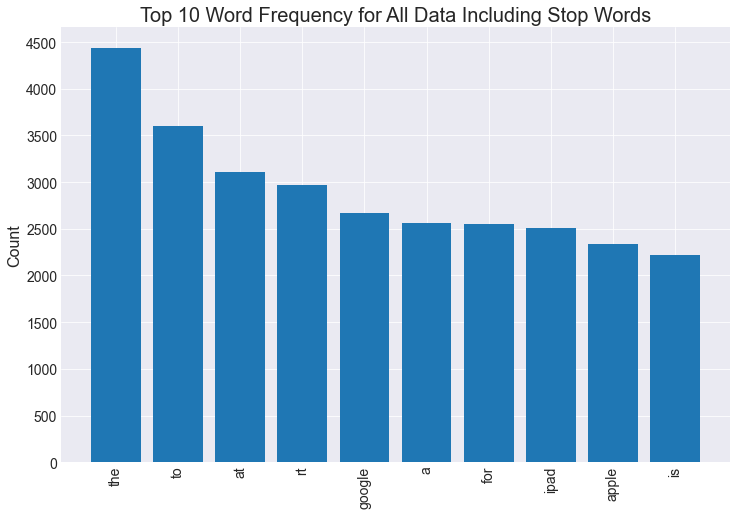

In [27]:
visualize_top_10(freq_dist, "Top 10 Word Frequency for All Data Including Stop Words")

Let's remove the stop words and look for patterns in between the labels and frequencies.

In [28]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [word for word in token_list if word not in stopwords.words('english')]

In [29]:
clean['tokened_text'] = clean['tokened_text'].apply(remove_stopwords)

In [30]:
clean['no_stop_text'] = clean['tokened_text'].apply(lambda x: ' '.join(x))

In [31]:
clean.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,tokened_text,no_stop_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,i have a 3g iphone after 3 hrs tweeting at ...,"[3g, iphone, 3, hr, tweeting, rise_austin, wa,...",3g iphone 3 hr tweeting rise_austin wa dead ne...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,know about awesome ipad iphone app that yo...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,can not wait for ipad 2 also they should sal...,"[wait, ipad, 2, also, sale]",wait ipad 2 also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,i hope this years festival is not as crashy a...,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google ...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim oreil...


Let's save a copy of the cleaned data, since this step took so long.

In [32]:
with open('data/clean_tweet_data.pickle', 'wb') as f:
    pickle.dump(clean, f)

In [33]:
with open('data/clean_tweet_data.pickle', 'rb') as file:
    clean = pickle.load(file)

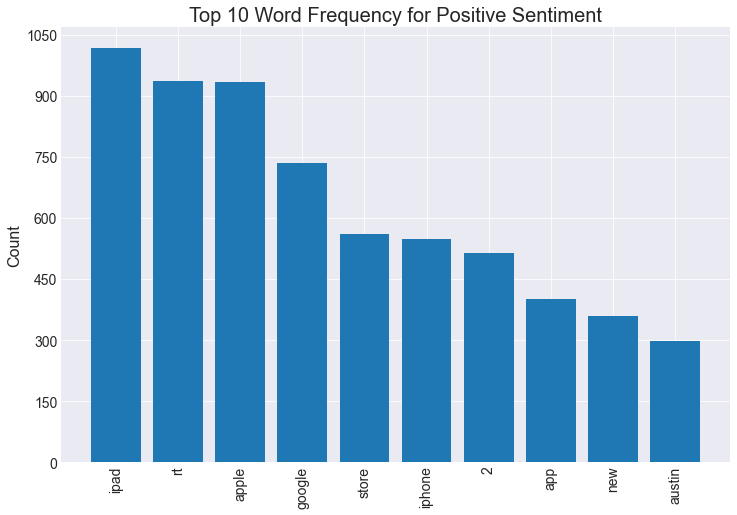

In [34]:
pos_data = clean[raw_data['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive']['tokened_text'].explode()
pos_freq_dist = FreqDist(pos_data)
visualize_top_10(pos_freq_dist, "Top 10 Word Frequency for Positive Sentiment")

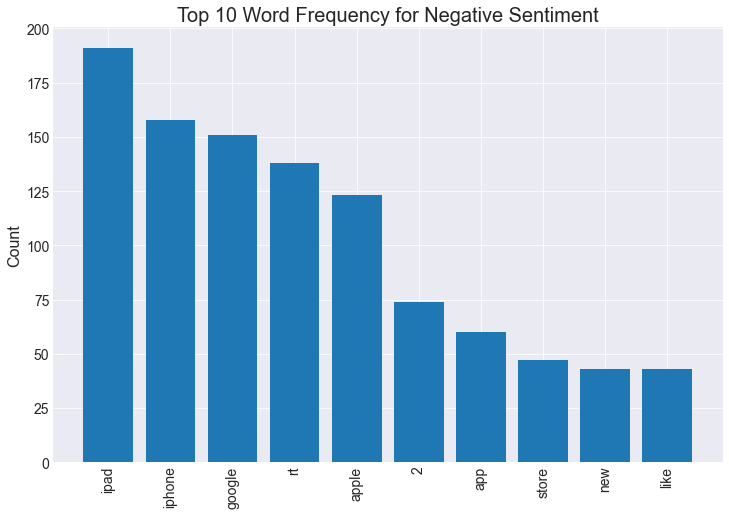

In [35]:
neg_data = clean[raw_data['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative']['tokened_text'].explode()
neg_freq_dist = FreqDist(neg_data)
visualize_top_10(neg_freq_dist, "Top 10 Word Frequency for Negative Sentiment")

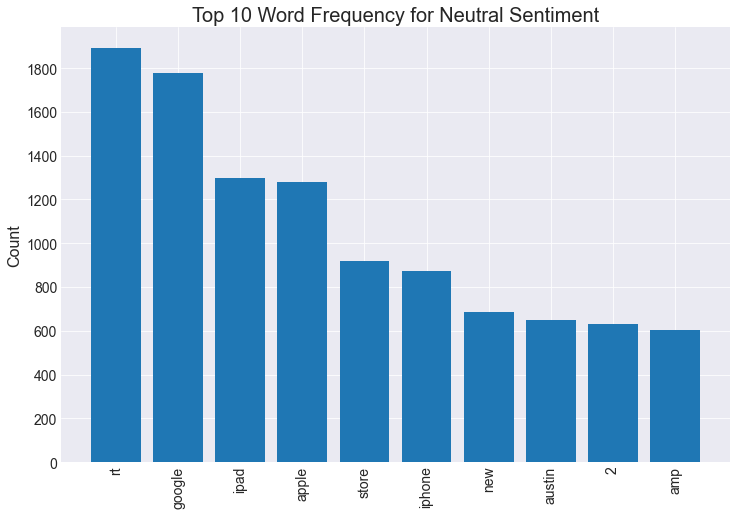

In [36]:
neutral_data = clean[raw_data['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion']['tokened_text'].explode()
neutral_freq_dist = FreqDist(neutral_data)
visualize_top_10(neutral_freq_dist, "Top 10 Word Frequency for Neutral Sentiment")

Most of the common words are very similar in the different label groups.

## Bigram Visualizations

In [37]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [38]:
bigram_measures = BigramAssocMeasures()
pos_finder = BigramCollocationFinder.from_words(pos_data)
pos_scored = pos_finder.score_ngrams(bigram_measures.raw_freq)

In [39]:
pos_scored[:10]

[(('ipad', '2'), 0.014054859289484764),
 (('apple', 'store'), 0.0073188898604229415),
 (('iphone', 'app'), 0.004469056640435247),
 (('pop', 'store'), 0.004469056640435247),
 (('google', 'map'), 0.0027850642831697917),
 (('social', 'network'), 0.0027850642831697917),
 (('apple', 'pop'), 0.0026879108779429384),
 (('rt', 'google'), 0.002558373004307134),
 (('new', 'social'), 0.002493604067489232),
 (('rt', 'apple'), 0.00242883513067133)]

In [40]:
neg_finder = BigramCollocationFinder.from_words(neg_data)
neg_scored = neg_finder.score_ngrams(bigram_measures.raw_freq)
neg_scored[:10]

[(('ipad', '2'), 0.00958994708994709),
 (('apple', 'store'), 0.004133597883597883),
 (('iphone', 'app'), 0.003968253968253968),
 (('rt', 'google'), 0.003472222222222222),
 (('ipad', 'design'), 0.0033068783068783067),
 (('design', 'headache'), 0.0028108465608465607),
 (('google', 'circle'), 0.0026455026455026454),
 (('new', 'social'), 0.0026455026455026454),
 (('social', 'network'), 0.00248015873015873),
 (('company', 'america'), 0.0021494708994708994)]

In [41]:
neutral_finder = BigramCollocationFinder.from_words(neutral_data)
neutral_scored = neutral_finder.score_ngrams(bigram_measures.raw_freq)
neutral_scored[:10]

[(('ipad', '2'), 0.008945023883213768),
 (('apple', 'store'), 0.006404637100381058),
 (('social', 'network'), 0.006368857004848203),
 (('new', 'social'), 0.005796375476322522),
 (('called', 'circle'), 0.004687192514804014),
 (('network', 'called'), 0.004615632323738304),
 (('rt', 'google'), 0.004544072132672594),
 (('google', 'launch'), 0.004472511941606884),
 (('major', 'new'), 0.004078930890745478),
 (('pop', 'store'), 0.004043150795212623)]

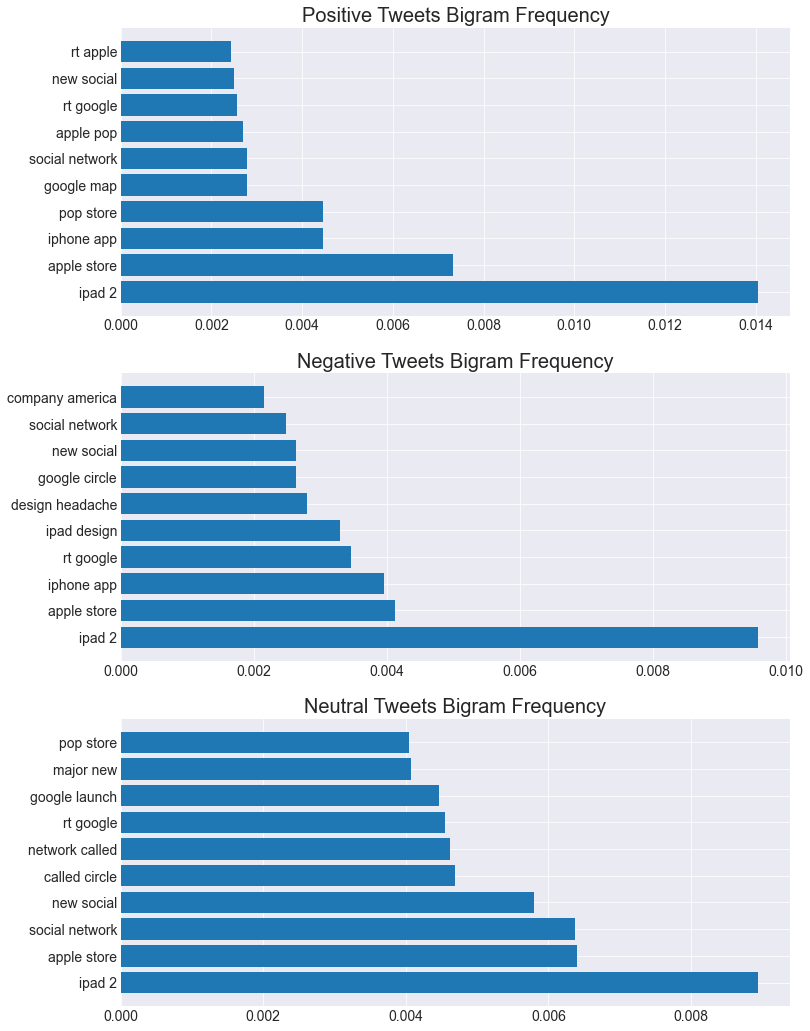

In [42]:
pos_x = [t[0][0]+' '+t[0][1] for t in pos_scored[:10]]
pos_y = [t[1] for t in pos_scored[:10]]
neg_x = [t[0][0]+' '+t[0][1] for t in neg_scored[:10]]
neg_y = [t[1] for t in neg_scored[:10]]
neutral_x = [t[0][0]+' '+t[0][1] for t in neutral_scored[:10]]
neutral_y = [t[1] for t in neutral_scored[:10]]
plt.figure(figsize = (12,18)) 
plt.subplot(3,1,1)
plt.barh(pos_x, pos_y)
plt.title('Positive Tweets Bigram Frequency')
plt.subplot(3,1,2)
plt.barh(neg_x, neg_y)
plt.title('Negative Tweets Bigram Frequency')
plt.subplot(3,1,3)
plt.title('Neutral Tweets Bigram Frequency')
plt.barh(neutral_x, neutral_y)
plt.show()

There is at least some difference in the bigrams. For example, design headaches and ipad design appear in the negative top ten most frequent.

### Mutual Information Score

In [43]:
pos_finder.apply_freq_filter(5)
pos_pmi_score = pos_finder.score_ngrams(bigram_measures.pmi)
neg_finder.apply_freq_filter(5)
neg_pmi_score = neg_finder.score_ngrams(bigram_measures.pmi)
neutral_finder.apply_freq_filter(5)
neutral_pmi_score = neutral_finder.score_ngrams(bigram_measures.pmi)

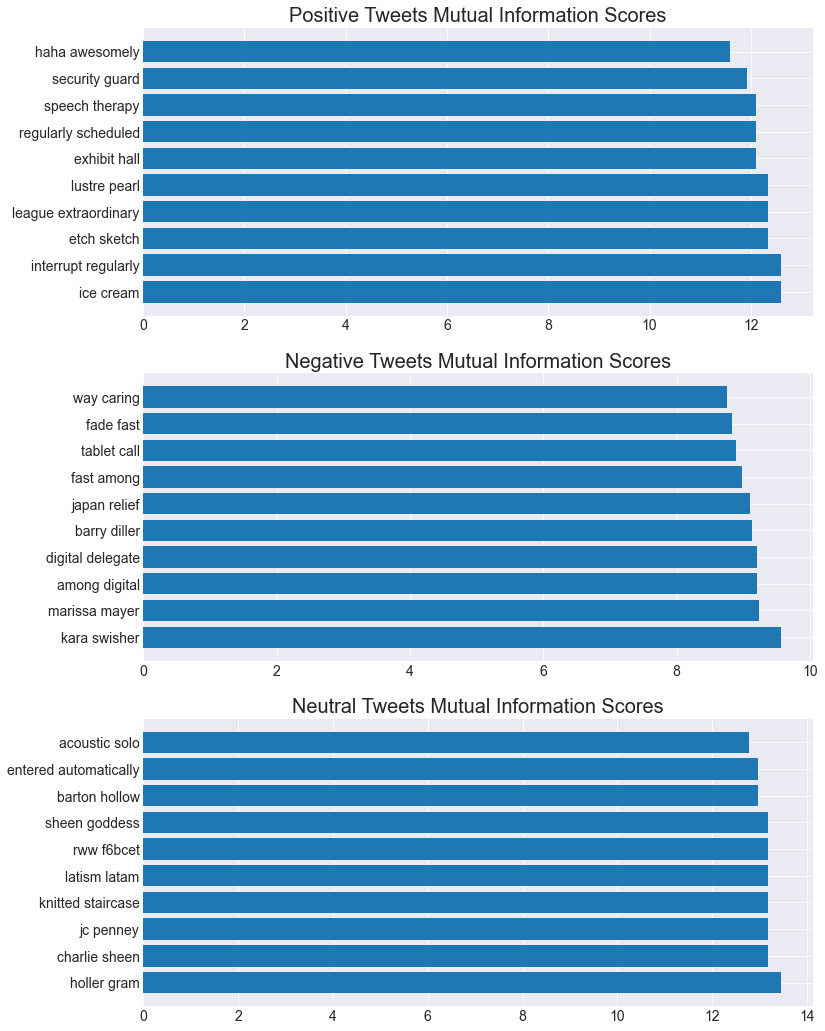

In [44]:
pos_x = [t[0][0]+' '+t[0][1] for t in pos_pmi_score[:10]]
pos_y = [t[1] for t in pos_pmi_score[:10]]
neg_x = [t[0][0]+' '+t[0][1] for t in neg_pmi_score[:10]]
neg_y = [t[1] for t in neg_pmi_score[:10]]
neutral_x = [t[0][0]+' '+t[0][1] for t in neutral_pmi_score[:10]]
neutral_y = [t[1] for t in neutral_pmi_score[:10]]
plt.figure(figsize = (12,18)) 
plt.subplot(3,1,1)
plt.barh(pos_x, pos_y)
plt.title('Positive Tweets Mutual Information Scores')
plt.subplot(3,1,2)
plt.barh(neg_x, neg_y)
plt.title('Negative Tweets Mutual Information Scores')
plt.subplot(3,1,3)
plt.title('Neutral Tweets Mutual Information Scores')
plt.barh(neutral_x, neutral_y)
plt.show()

The mutual information scores are signficantly different.

# Building a Baseline Model

Let's begin by dividing the data into test and training sets. We will try a few different approaches before we decide what model to tune including a naive bayesian classifier, a random forest model, and an RNN.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
with open('data/clean_tweet_data.pickle', 'rb') as file:
    clean = pickle.load(file)

In [47]:
label = LabelEncoder()
X = clean['cleaned_text']
y = label.fit_transform(clean['is_there_an_emotion_directed_at_a_brand_or_product'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayesian Classifier

A naive bayesian classifier has an accuracy of about 64% on both the training and test data, which is not amazing given how imbalanced the data is, and an F1 score of 56%.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [49]:
tfidf = TfidfVectorizer(max_features=100, stop_words=stopwords.words('english'))
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

In [50]:
bayes_model = MultinomialNB()
bayes_cv = cross_val_score(bayes_model, X_train_vectorized, y_train)
bayes_cv

array([0.64261168, 0.65704467, 0.64948454, 0.63823934, 0.63480055])

In [51]:
bayes_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [52]:
dp.get_scores(bayes_model, X_test_vectorized, y_test)

C:\Users\lelwo\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.6355140186915887,
 'Precision': 0.5905165637168031,
 'Recall': 0.6355140186915887,
 'F1 Score': 0.5599482452508959}

#### Training Confusion Matrix

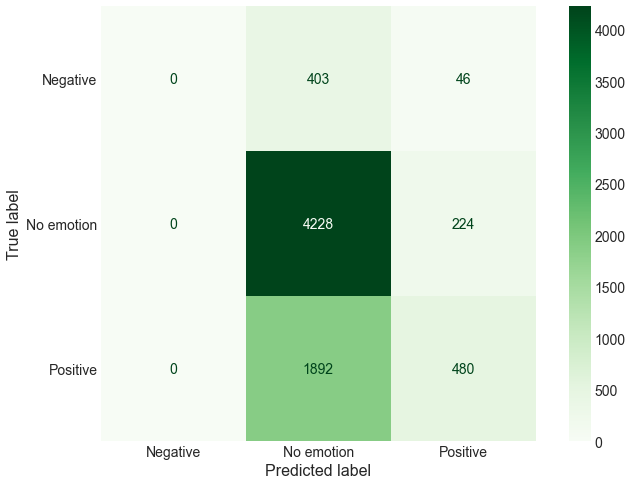

In [53]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### Test Confusion Matrix

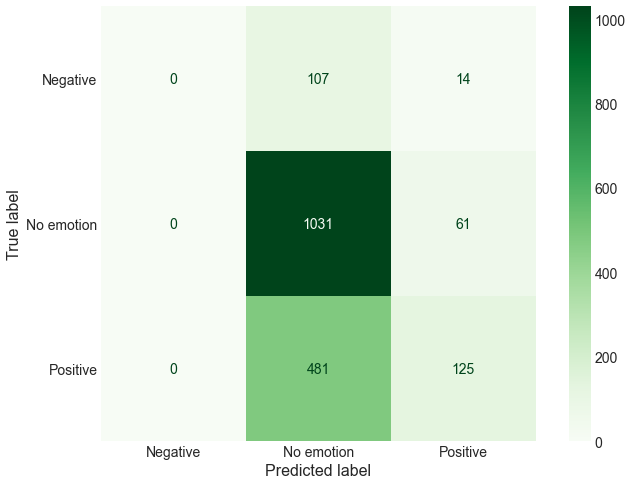

In [54]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

Given the low prior probability of being in the negative catgory, we can see that the model is mostly just throwing things into the "no emotion category. Clearly class imbalance is a big deal in this data.

### Random Forest

A baseline random forest classifier has an accuracy of about 63% on the training and test data and an F1 score of 60%

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
forest_model = RandomForestClassifier()
forest_cv = cross_val_score(forest_model, X_train_vectorized, y_train)
forest_cv

array([0.63161512, 0.64467354, 0.64398625, 0.63617607, 0.6389271 ])

In [57]:
forest_model.fit(X_train_vectorized, y_train)

RandomForestClassifier()

In [58]:
dp.get_scores(forest_model, X_test_vectorized, y_test)

{'Accuracy': 0.6272677295217153,
 'Precision': 0.5966369873891908,
 'Recall': 0.6272677295217153,
 'F1 Score': 0.5975293304279478}

#### Training Confusion Matrix

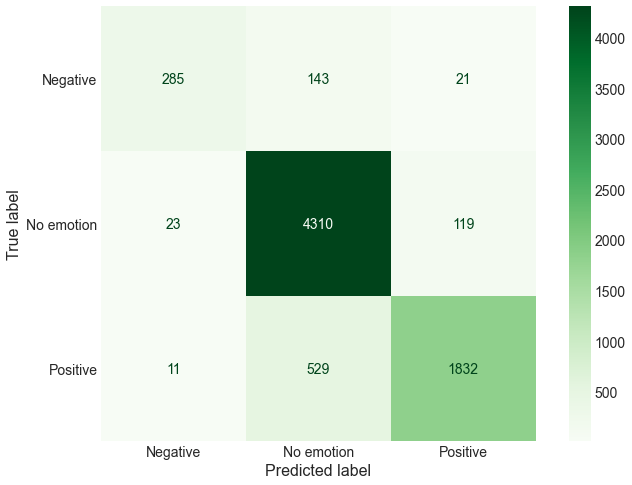

In [59]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### Test Confusion Matrix

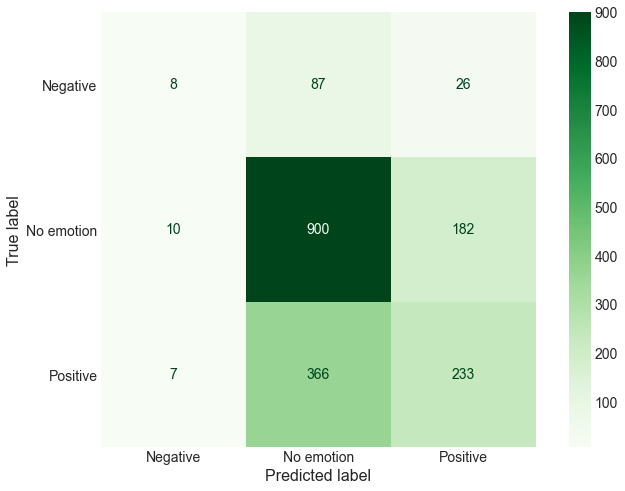

In [60]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

The random forest only does marginally better with the negative sentiment class. 

### Logisitic Regression

A basic logisic regression model has an accuracy of about 64% on the training and 62% on the test data. I has an F1 score of about 58%.

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
logistic_model = LogisticRegression()
logistic_cv = cross_val_score(logistic_model, X_train_vectorized, y_train)
logistic_cv

array([0.65360825, 0.65429553, 0.63505155, 0.64305365, 0.64167813])

In [63]:
logistic_model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [64]:
dp.get_scores(logistic_model, X_test_vectorized, y_test)

C:\Users\lelwo\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.6234194612424409,
 'Precision': 0.5647876055000037,
 'Recall': 0.6234194612424409,
 'F1 Score': 0.5788522531516839}

#### Training Confusion Matrix

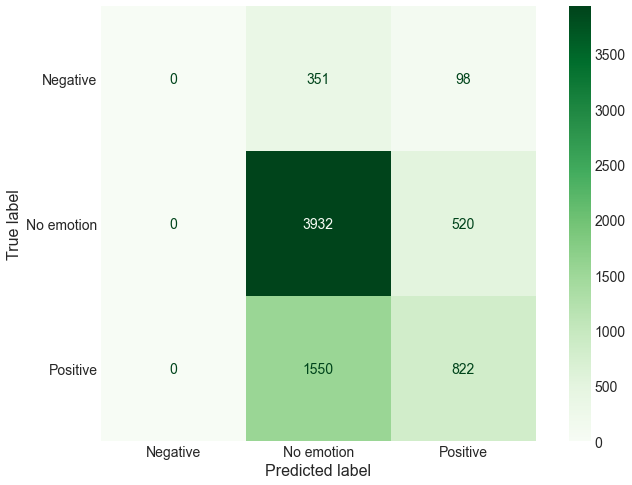

In [65]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### Test Confusion Matrix

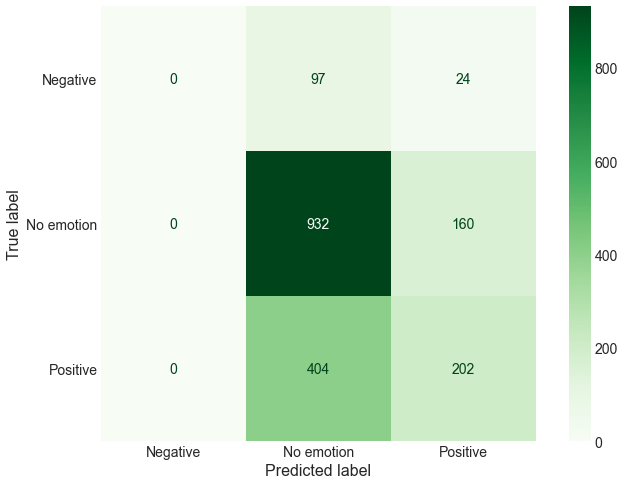

In [66]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

The logistic model, much like the bayesian is just assuming nothing goes in the negative class.

### Support Vector Machine

A basic support vector classifier model has an accuracy of about 65% on the training and test data. I has an F1 score of about 59%.

In [67]:
from sklearn.svm import SVC

In [68]:
svm_model = SVC()
svm_cv = cross_val_score(svm_model, X_train_vectorized, y_train)
svm_cv

array([0.64879725, 0.66804124, 0.65704467, 0.66093535, 0.65268226])

In [69]:
svm_model.fit(X_train_vectorized, y_train)

SVC()

In [70]:
dp.get_scores(svm_model, X_test_vectorized, y_test)

{'Accuracy': 0.6492578339747114,
 'Precision': 0.6648420054097047,
 'Recall': 0.6492578339747114,
 'F1 Score': 0.593173980121767}

#### Training Confusion Matrix

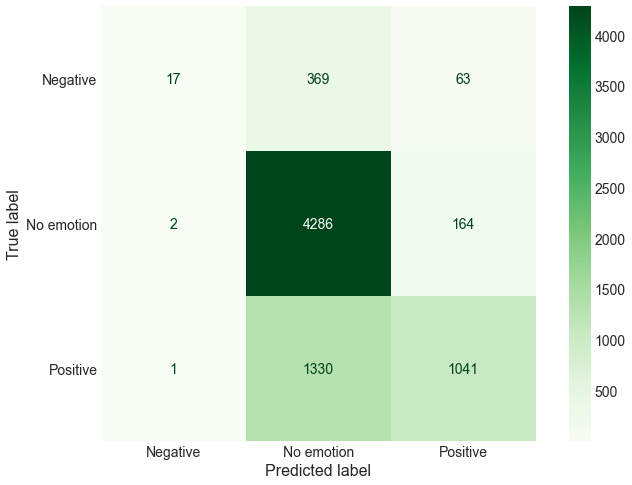

In [71]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### Test Confusion Matrix

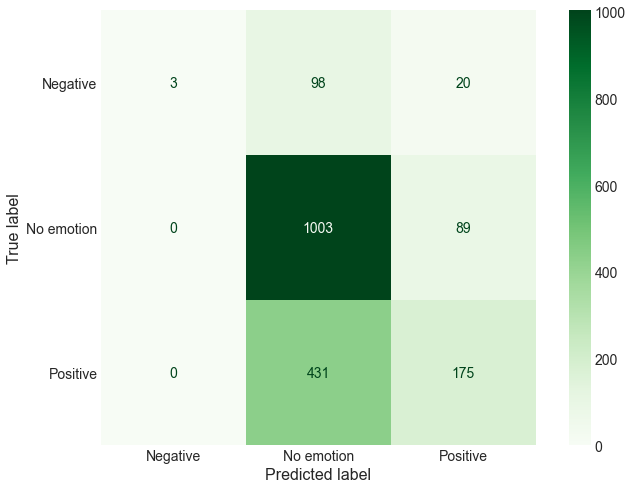

In [72]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

The SVM machine is the only model other than the random forest so far that categorizes any negative sentiment tweets, but performs worse than the forest model by this metric.

### Basic RNN

A neural nework with an embedding layer of 128, a LSTM layer with 25 nodes, and an additional dense layer of 50, with 50% drop out between layers trained for 5 epochs has an accuracy of about 87% on the training and 67% test data. I has an F1 score of about 87% on the training and 65% on the test data.

In [112]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [113]:
y_one_hot = pd.get_dummies(clean['is_there_an_emotion_directed_at_a_brand_or_product']).values
X_rnn = clean['no_stop_text']
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_one_hot, test_size=0.2, random_state=42)

In [114]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
train_list_tokenized = tokenizer.texts_to_sequences(X_train_rnn)
X_train_padded = sequence.pad_sequences(train_list_tokenized, maxlen=100)
test_list_tokenized = tokenizer.texts_to_sequences(X_test_rnn)
X_test_padded = sequence.pad_sequences(test_list_tokenized, maxlen=100)

In [115]:
baseline_rnn = Sequential()
embedding_size = 128
baseline_rnn.add(Embedding(20000, embedding_size))
baseline_rnn.add(LSTM(25, return_sequences=True))
baseline_rnn.add(GlobalMaxPool1D())
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(50, activation='relu'))
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(3, activation='softmax'))

In [116]:
baseline_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [117]:
baseline_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_5 (LSTM)               (None, None, 25)          15400     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 25)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                1300      
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                      

In [118]:
baseline_rnn_val = baseline_rnn.fit(X_train_padded, y_train_rnn, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
205/205 [==============================] - 11s 48ms/step - loss: 0.9107 - accuracy: 0.5807 - val_loss: 0.7984 - val_accuracy: 0.6511
Epoch 2/5
205/205 [==============================] - 9s 45ms/step - loss: 0.8094 - accuracy: 0.6240 - val_loss: 0.7165 - val_accuracy: 0.6854
Epoch 3/5
205/205 [==============================] - 9s 46ms/step - loss: 0.6557 - accuracy: 0.7332 - val_loss: 0.7314 - val_accuracy: 0.6978
Epoch 4/5
205/205 [==============================] - 9s 45ms/step - loss: 0.5237 - accuracy: 0.7979 - val_loss: 0.7509 - val_accuracy: 0.6992
Epoch 5/5
205/205 [==============================] - 10s 48ms/step - loss: 0.4202 - accuracy: 0.8429 - val_loss: 0.8814 - val_accuracy: 0.6896


In [119]:
baseline_rnn_val_dict = baseline_rnn_val.history

#### Metrics

This model is the most accurate and has the highest F1 of those tested.

In [120]:
baseline_metrics = dp.get_network_metrics(baseline_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 8ms/step - loss: 0.3334 - accuracy: 0.8818
----------
Training Loss: 0.333 
Training Accuracy: 0.882
Train F1 Score: 0.8799214130582077
Train Recall on Rarest Category: 0.7260579064587973
57/57 [==============================] - 0s 8ms/step - loss: 0.9680 - accuracy: 0.6619
----------
Test Loss: 0.968 
Test Accuracy: 0.662
Test F1 Score: 0.6535745385833527
Test Recall on Rarest Category: 0.2975206611570248


#### Confusion Matrices

We can see that the RNN does the best so far at classifying the negative examples.

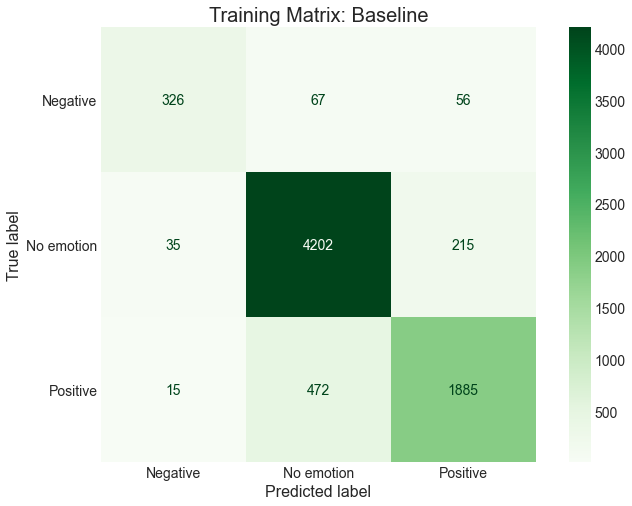

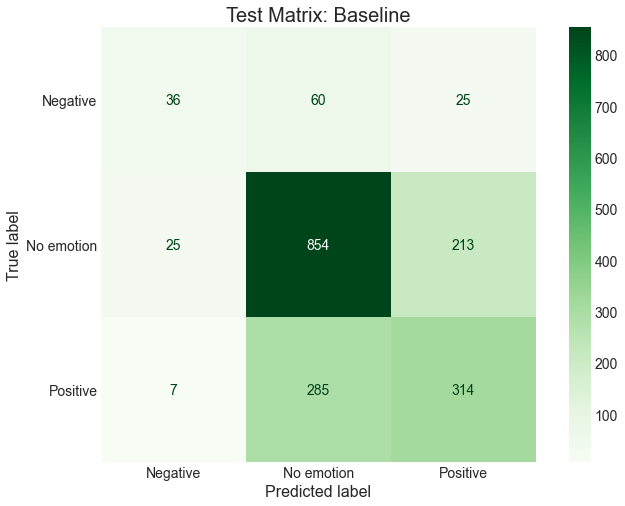

In [121]:
viz.make_network_confusion_matrices(baseline_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline')

We can see from graphing the data, that the model starts significantly overfitting after about 3 epochs

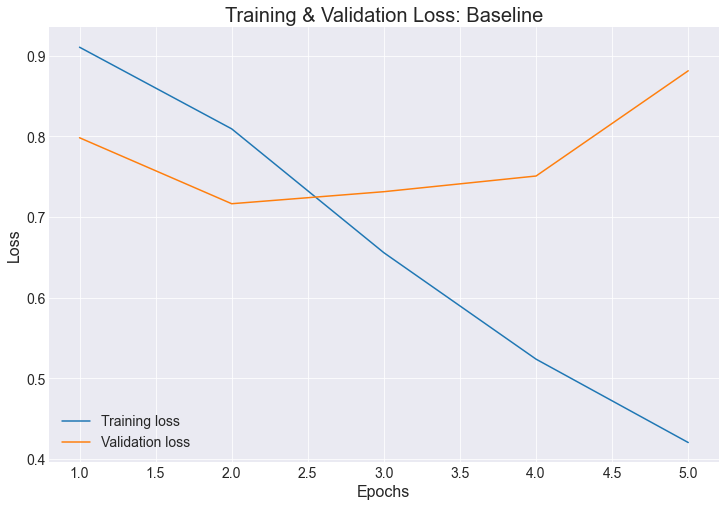

In [122]:
viz.training_graph(baseline_rnn_val_dict, 'Baseline')

## Tuning the Model

### *Dealing with Class Imbalance*

One clear issue is the major class imbalance particularly with the negative sentiment data being so rare in this particular dataset. Maybe gathering data from the #SXSW tag was a bad idea if you want a representative sample of sentiment, but we have to deal with the data we have.

We might attempt to make a weighted  model or oversample the data to deal with it, but oversampling isn't particularly useful with text data since it just duplicates the tweets at best and could make nonsense at worst, so we wll just weight the data.

Let's go with the RNN since that performed the best anyway.

In [123]:
from sklearn.utils import class_weight

In [124]:
y_integers = np.argmax(y_train_rnn, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 5.399406087602078, 1: 0.5445492662473794, 2: 1.0220629567172568}

In [125]:
weighted_rnn = Sequential()
embedding_size = 128
weighted_rnn.add(Embedding(20000, embedding_size))
weighted_rnn.add(LSTM(25, return_sequences=True))
weighted_rnn.add(GlobalMaxPool1D())
weighted_rnn.add(Dropout(0.5))
weighted_rnn.add(Dense(50, activation='relu'))
weighted_rnn.add(Dropout(0.5))
weighted_rnn.add(Dense(3, activation='softmax'))
weighted_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [126]:
weighted_rnn_val = weighted_rnn.fit(X_train_padded,
                                    y_train_rnn,
                                    epochs=5,
                                    batch_size=32,
                                    validation_split=0.1, 
                                    class_weight= d_class_weights)

Epoch 1/5
205/205 [==============================] - 11s 48ms/step - loss: 1.0999 - accuracy: 0.3888 - val_loss: 1.0490 - val_accuracy: 0.5673
Epoch 2/5
205/205 [==============================] - 9s 45ms/step - loss: 0.9705 - accuracy: 0.5010 - val_loss: 0.8655 - val_accuracy: 0.6071
Epoch 3/5
205/205 [==============================] - 9s 44ms/step - loss: 0.6955 - accuracy: 0.6368 - val_loss: 0.8596 - val_accuracy: 0.6168
Epoch 4/5
205/205 [==============================] - 9s 45ms/step - loss: 0.5259 - accuracy: 0.7439 - val_loss: 0.8318 - val_accuracy: 0.6456
Epoch 5/5
205/205 [==============================] - 9s 45ms/step - loss: 0.4274 - accuracy: 0.7969 - val_loss: 0.8760 - val_accuracy: 0.6703


In [127]:
weighted_rnn_val_dict = weighted_rnn_val.history

#### Metrics

The weighted model has worse performance on accuracy and F1 score, but has significant gains for the rare category.

In [128]:
weighted_metrics = dp.get_network_metrics(weighted_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 8ms/step - loss: 0.4021 - accuracy: 0.8547
----------
Training Loss: 0.402 
Training Accuracy: 0.855
Train F1 Score: 0.8557442666651887
Train Recall on Rarest Category: 0.9242761692650334
57/57 [==============================] - 0s 8ms/step - loss: 0.9511 - accuracy: 0.6333
----------
Test Loss: 0.951 
Test Accuracy: 0.633
Test F1 Score: 0.636220903062932
Test Recall on Rarest Category: 0.39669421487603307


#### Confusion Matrices

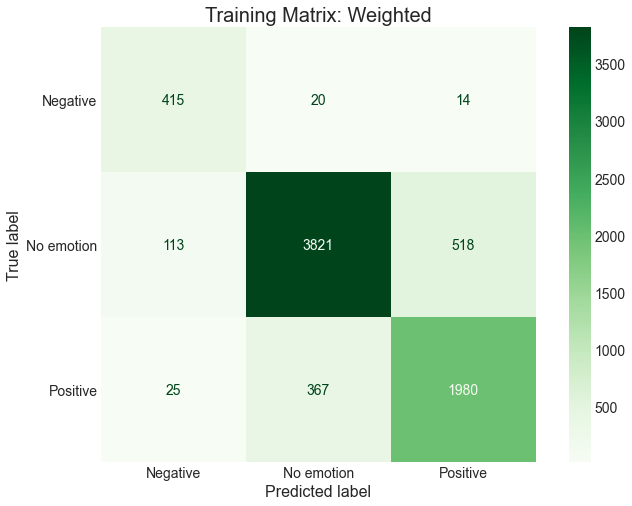

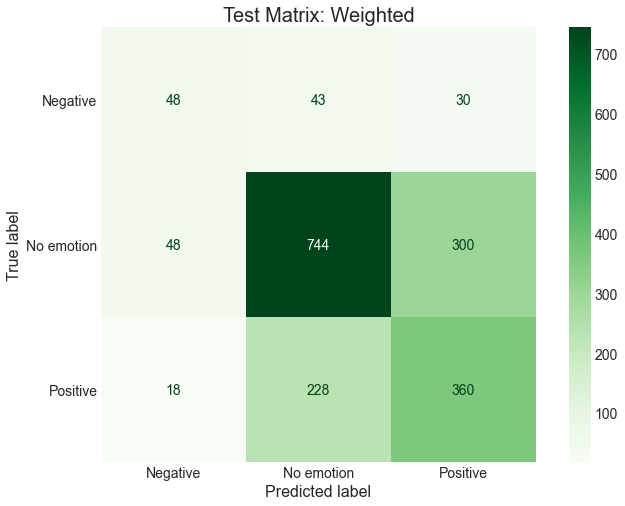

In [129]:
viz.make_network_confusion_matrices(weighted_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted')

The weighted model is also showing significant signs of overfitting after just three training epochs.

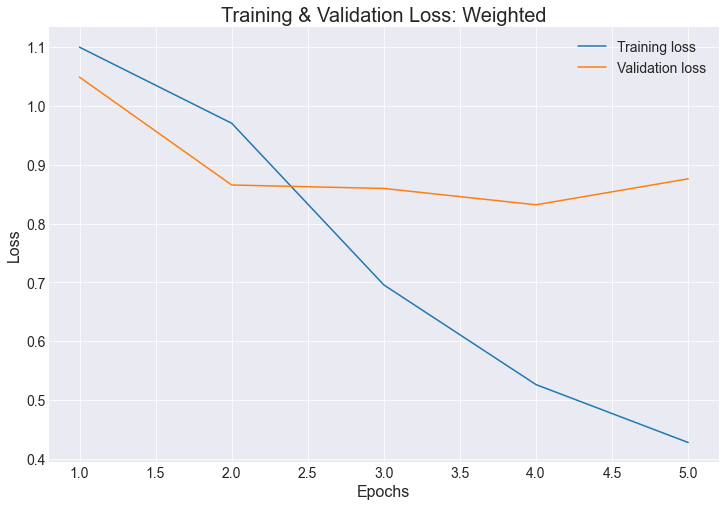

In [130]:
viz.training_graph(weighted_rnn_val_dict, 'Weighted')

### *Using GloVe Embeddeding*

One way we might attempt to improve the model's performance is to use a pretrained embedding rather than training one within the model. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. It can be found here: https://nlp.stanford.edu/projects/glove/

To begin we will collect the parts of the GloVe vector relevant to our data.

In [131]:
word_index = tokenizer.word_index
print('There are {} unique tokens in the dataset.'.format(len(word_index)))

There are 8813 unique tokens in the dataset.


In [132]:
glove = {}
with open('glove.twitter.27B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_index.keys():
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [133]:
glove['love']

array([-4.8371e-01, -2.7318e-01, -4.6840e-02,  7.0274e-01, -5.6301e-01,
       -1.7214e-01,  8.1775e-01, -6.6641e-02,  2.0224e-02, -2.3878e-01,
       -1.6122e-02, -1.7875e-01, -4.9281e+00, -4.0272e-01, -4.1190e-01,
       -1.4570e-01,  1.8508e-01, -1.9116e-01, -8.4608e-01,  6.5378e-01,
        1.2370e-01,  4.8835e-02, -3.3709e-01,  2.5834e-01,  4.7729e-01,
       -8.8145e-01, -1.3083e-01,  7.9499e-01,  8.6216e-02, -9.1803e-01,
       -9.6671e-01, -4.8309e-01, -4.0963e-01,  1.6920e-01,  2.3241e-01,
       -2.0524e-02,  2.2267e-01, -2.6763e-01,  1.4378e-01, -4.6547e-02,
       -1.1726e+00, -3.5298e-02,  2.8347e-01,  4.3446e-01,  1.8472e-01,
        3.3065e-01,  6.7848e-02, -7.6485e-01,  1.8351e-01, -6.4361e-01,
       -7.5015e-01, -4.2583e-02,  2.4262e-01, -6.4108e-01,  6.9741e-01,
       -2.3133e-01, -2.1454e-01,  3.1040e-01,  2.3161e-01,  6.8397e-02,
        8.1428e-02, -3.9331e-01, -1.0927e+00, -4.2618e-02, -9.6970e-02,
        3.1243e-01, -1.0463e+00,  2.8207e-01, -7.2446e-01,  3.14

We will next construct an embedding martrix, so we can use the GloVe vectors in an embedding layer.

In [134]:
embedding_matrix = np.zeros((len(word_index) + 1, 100)) # 100 dimensions since we used 100 dimensional glove vectors
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Next, we will make the embedding layer. It will be untrainable, since we want to retain the information from the pretrained vectors.

In [135]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [152]:
glove_rnn = Sequential()
glove_rnn.add(embedding_layer)
glove_rnn.add(LSTM(25, return_sequences=True))
glove_rnn.add(GlobalMaxPool1D())
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(50, activation='relu'))
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(3, activation='softmax'))
glove_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [153]:
glove_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          881400    
                                                                 
 lstm_10 (LSTM)              (None, 100, 25)           12600     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 25)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 25)                0         
                                                                 
 dense_20 (Dense)            (None, 50)                1300      
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                     

The GloVe model will take more training epoches to reach the same score since it has less nodes to vary during training.

In [154]:
glove_rnn_val = glove_rnn.fit(X_train_padded,
                              y_train_rnn,epochs=20,
                              batch_size=32,
                              validation_split=0.1)                            

Epoch 1/20
205/205 [==============================] - 7s 26ms/step - loss: 0.8961 - accuracy: 0.5829 - val_loss: 0.8216 - val_accuracy: 0.6511
Epoch 2/20
205/205 [==============================] - 5s 24ms/step - loss: 0.8395 - accuracy: 0.6060 - val_loss: 0.7683 - val_accuracy: 0.6525
Epoch 3/20
205/205 [==============================] - 5s 24ms/step - loss: 0.8134 - accuracy: 0.6194 - val_loss: 0.7540 - val_accuracy: 0.6772
Epoch 4/20
205/205 [==============================] - 5s 24ms/step - loss: 0.7917 - accuracy: 0.6362 - val_loss: 0.7391 - val_accuracy: 0.6937
Epoch 5/20
205/205 [==============================] - 5s 24ms/step - loss: 0.7760 - accuracy: 0.6494 - val_loss: 0.7190 - val_accuracy: 0.6978
Epoch 6/20
205/205 [==============================] - 5s 25ms/step - loss: 0.7574 - accuracy: 0.6555 - val_loss: 0.6960 - val_accuracy: 0.6978
Epoch 7/20
205/205 [==============================] - 6s 30ms/step - loss: 0.7363 - accuracy: 0.6668 - val_loss: 0.6826 - val_accuracy: 0.6951

In [155]:
glove_rnn_val_dict = glove_rnn_val.history

#### Metrics

There is a marginal improvement in the F1 score over the baseline model. The GloVe model also performs a bit better on the negative data than the baseline model, but a lot worse than the weighted model.

In [156]:
glove_metrics = dp.get_network_metrics(glove_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 9ms/step - loss: 0.5462 - accuracy: 0.7657
----------
Training Loss: 0.546 
Training Accuracy: 0.766
Train F1 Score: 0.7489491487882279
Train Recall on Rarest Category: 0.267260579064588
57/57 [==============================] - 1s 9ms/step - loss: 0.7337 - accuracy: 0.6800
----------
Test Loss: 0.734 
Test Accuracy: 0.68
Test F1 Score: 0.6549350113800343
Test Recall on Rarest Category: 0.18181818181818182


#### Confusion Matrices

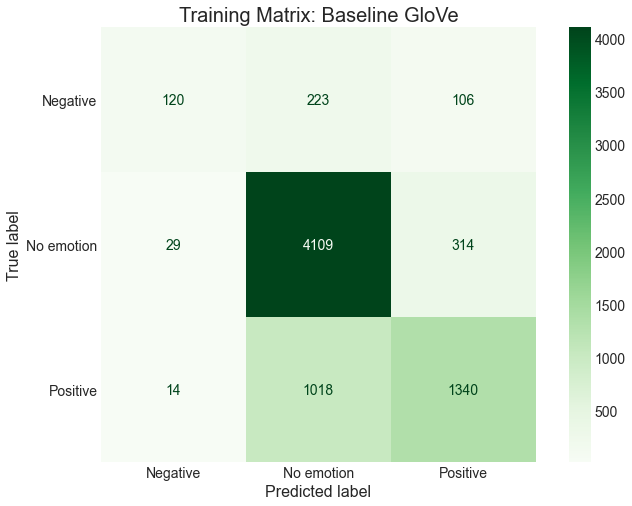

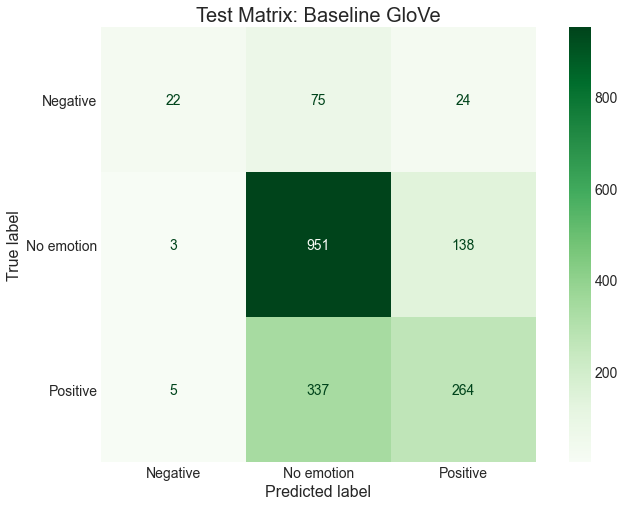

In [157]:
viz.make_network_confusion_matrices(glove_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline GloVe')

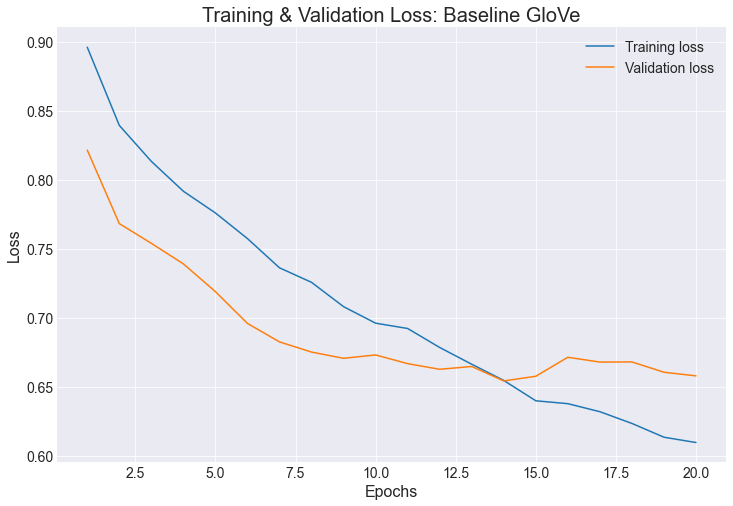

In [158]:
viz.training_graph(glove_rnn_val_dict, 'Baseline GloVe')

### *Weighted GloVe*

In [159]:
wglove_rnn = Sequential()
wglove_rnn.add(embedding_layer)
wglove_rnn.add(LSTM(25, return_sequences=True))
wglove_rnn.add(GlobalMaxPool1D())
wglove_rnn.add(Dropout(0.5))
wglove_rnn.add(Dense(50, activation='relu'))
wglove_rnn.add(Dropout(0.5))
wglove_rnn.add(Dense(3, activation='softmax'))
wglove_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [160]:
wglove_rnn_val = wglove_rnn.fit(X_train_padded,
                              y_train_rnn,epochs=25,
                              batch_size=32,
                              validation_split=0.1,
                               class_weight= d_class_weights)    

Epoch 1/25
205/205 [==============================] - 7s 28ms/step - loss: 1.1060 - accuracy: 0.3617 - val_loss: 1.0924 - val_accuracy: 0.3874
Epoch 2/25
205/205 [==============================] - 5s 25ms/step - loss: 1.0650 - accuracy: 0.3812 - val_loss: 1.0394 - val_accuracy: 0.4876
Epoch 3/25
205/205 [==============================] - 5s 25ms/step - loss: 1.0298 - accuracy: 0.4202 - val_loss: 1.0215 - val_accuracy: 0.5096
Epoch 4/25
205/205 [==============================] - 5s 26ms/step - loss: 1.0030 - accuracy: 0.4523 - val_loss: 0.9970 - val_accuracy: 0.5412
Epoch 5/25
205/205 [==============================] - 5s 25ms/step - loss: 0.9521 - accuracy: 0.4879 - val_loss: 0.9631 - val_accuracy: 0.5522
Epoch 6/25
205/205 [==============================] - 5s 25ms/step - loss: 0.9331 - accuracy: 0.5175 - val_loss: 0.8922 - val_accuracy: 0.6085
Epoch 7/25
205/205 [==============================] - 5s 24ms/step - loss: 0.9125 - accuracy: 0.5288 - val_loss: 0.8593 - val_accuracy: 0.6401

In [161]:
wglove_rnn_val_dict = wglove_rnn_val.history

#### Metrics

The weights substantially lowered the accuracy and F1 scores. It did improve the performance on negative data significantly over the unweighted GloVe model, but has a lower recall than the baseline weighted model.

In [162]:
wglove_metrics = dp.get_network_metrics(wglove_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 8ms/step - loss: 0.6500 - accuracy: 0.6993
----------
Training Loss: 0.65 
Training Accuracy: 0.699
Train F1 Score: 0.7040572732409391
Train Recall on Rarest Category: 0.9420935412026726
57/57 [==============================] - 0s 8ms/step - loss: 0.7998 - accuracy: 0.6124
----------
Test Loss: 0.8 
Test Accuracy: 0.612
Test F1 Score: 0.6208725682372697
Test Recall on Rarest Category: 0.5371900826446281


#### Confusion Matrices

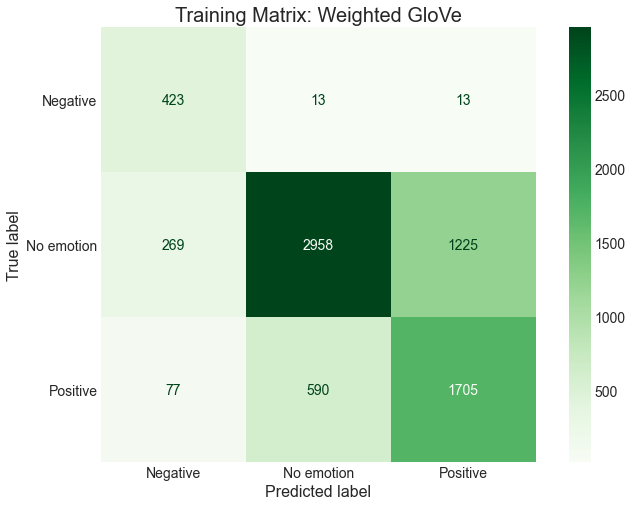

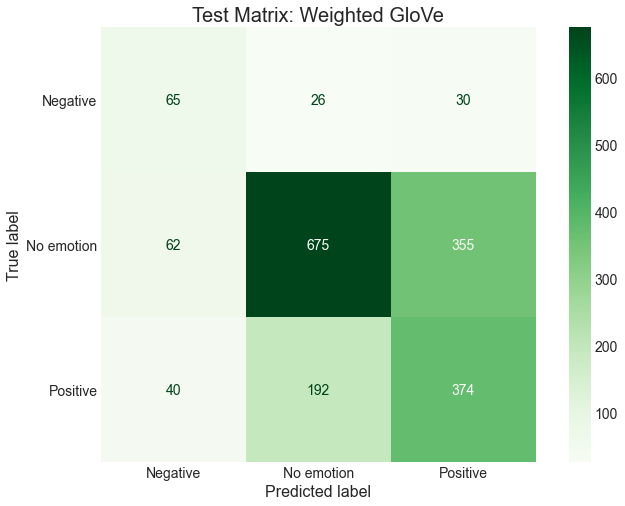

In [163]:
viz.make_network_confusion_matrices(wglove_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted GloVe')

There are signs of overfitting around 15 epochs and the drop in the validation score is more stochastic using the weighted data.

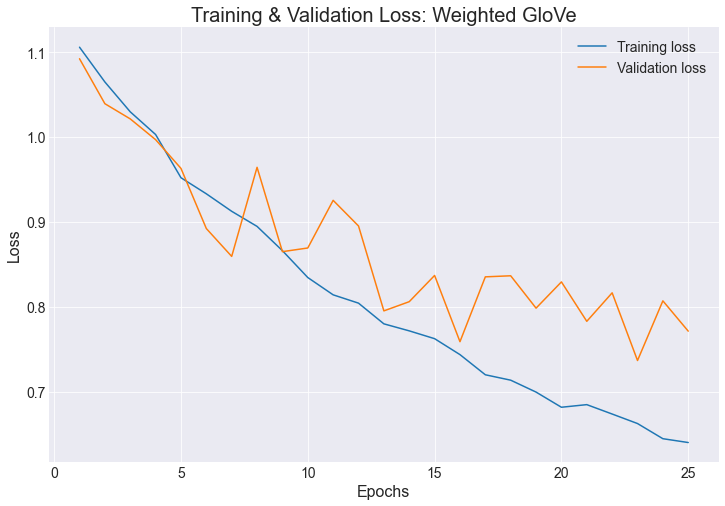

In [164]:
viz.training_graph(wglove_rnn_val_dict, 'Weighted GloVe')

### *Altering Nodes to RNN Layer of GloVe Model*

Let's begin by testing to see if increasing the number LSTM layer nodes and decrease training to 5 epochs has any noticable effect.

In [165]:
more_lstm_rnn = Sequential()
embedding_size = 128
more_lstm_rnn.add(embedding_layer)
more_lstm_rnn.add(LSTM(50, return_sequences=True))
more_lstm_rnn.add(GlobalMaxPool1D())
more_lstm_rnn.add(Dropout(0.5))
more_lstm_rnn.add(Dense(50, activation='relu'))
more_lstm_rnn.add(Dropout(0.5))
more_lstm_rnn.add(Dense(3, activation='softmax'))
more_lstm_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [166]:
more_lstm_rnn_val = more_lstm_rnn.fit(X_train_padded,
                                      y_train_rnn,epochs=15, 
                                      batch_size=32,
                                      validation_split=0.1)

Epoch 1/15
205/205 [==============================] - 8s 31ms/step - loss: 0.8761 - accuracy: 0.5862 - val_loss: 0.7837 - val_accuracy: 0.6511
Epoch 2/15
205/205 [==============================] - 6s 29ms/step - loss: 0.8200 - accuracy: 0.6089 - val_loss: 0.7530 - val_accuracy: 0.6827
Epoch 3/15
205/205 [==============================] - 6s 29ms/step - loss: 0.7979 - accuracy: 0.6273 - val_loss: 0.7237 - val_accuracy: 0.6992
Epoch 4/15
205/205 [==============================] - 6s 29ms/step - loss: 0.7743 - accuracy: 0.6388 - val_loss: 0.7051 - val_accuracy: 0.6978
Epoch 5/15
205/205 [==============================] - 6s 31ms/step - loss: 0.7437 - accuracy: 0.6597 - val_loss: 0.6852 - val_accuracy: 0.7005
Epoch 6/15
205/205 [==============================] - 6s 29ms/step - loss: 0.7264 - accuracy: 0.6652 - val_loss: 0.6717 - val_accuracy: 0.7157
Epoch 7/15
205/205 [==============================] - 6s 29ms/step - loss: 0.7033 - accuracy: 0.6883 - val_loss: 0.6636 - val_accuracy: 0.7239

In [167]:
more_lstm_rnn_val_dict = more_lstm_rnn_val.history

#### Metrics

This model does very similar on F1 score and accuracy to the initial GloVe model. This model does better on the rare negative data than the initial GloVe model.

In [168]:
more_lstm_metrics = dp.get_network_metrics(more_lstm_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 11ms/step - loss: 0.5130 - accuracy: 0.7839
----------
Training Loss: 0.513 
Training Accuracy: 0.784
Train F1 Score: 0.7778003946779135
Train Recall on Rarest Category: 0.45657015590200445
57/57 [==============================] - 1s 11ms/step - loss: 0.7258 - accuracy: 0.6696
----------
Test Loss: 0.726 
Test Accuracy: 0.67
Test F1 Score: 0.6550966970415327
Test Recall on Rarest Category: 0.21487603305785125


#### Confusion Matrices

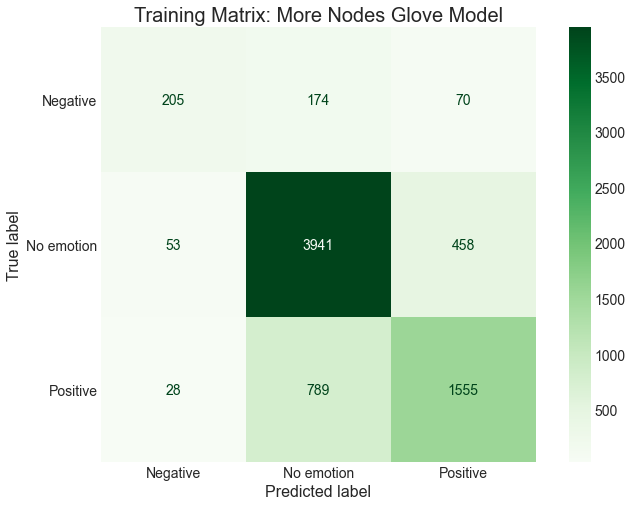

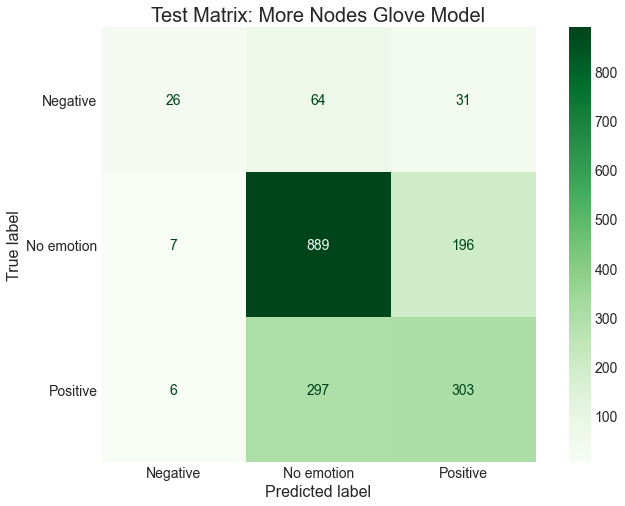

In [169]:
viz.make_network_confusion_matrices(more_lstm_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'More Nodes Glove Model')

There are clear signs of overfitting in the plateau of the validation scores.

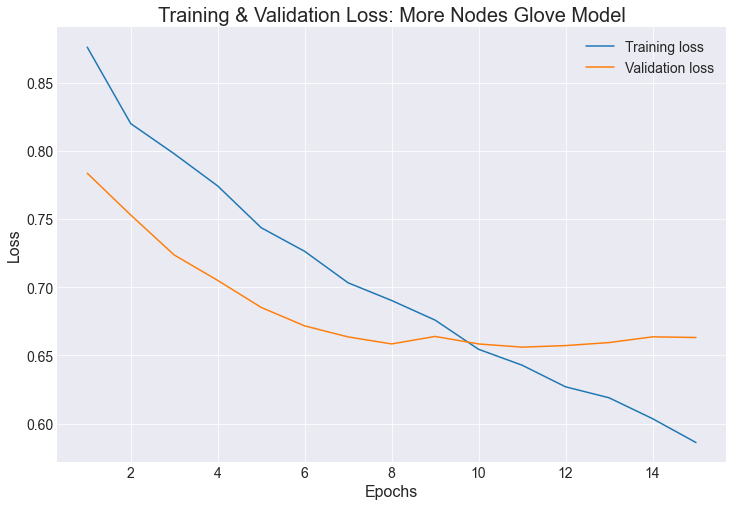

In [170]:
viz.training_graph(more_lstm_rnn_val_dict, 'More Nodes Glove Model')

### *Adding Weighting*

In [171]:
w_more_lstm_rnn = Sequential()
embedding_size = 128
w_more_lstm_rnn.add(embedding_layer)
w_more_lstm_rnn.add(LSTM(50, return_sequences=True))
w_more_lstm_rnn.add(GlobalMaxPool1D())
w_more_lstm_rnn.add(Dropout(0.5))
w_more_lstm_rnn.add(Dense(50, activation='relu'))
w_more_lstm_rnn.add(Dropout(0.5))
w_more_lstm_rnn.add(Dense(3, activation='softmax'))
w_more_lstm_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [172]:
w_more_lstm_rnn_val = w_more_lstm_rnn.fit(X_train_padded,
                                      y_train_rnn,epochs=15, 
                                      batch_size=64,
                                      validation_split=0.1,
                                       class_weight= d_class_weights)

Epoch 1/15
103/103 [==============================] - 6s 47ms/step - loss: 1.1135 - accuracy: 0.3574 - val_loss: 1.0767 - val_accuracy: 0.3942
Epoch 2/15
103/103 [==============================] - 4s 43ms/step - loss: 1.0739 - accuracy: 0.3710 - val_loss: 1.1267 - val_accuracy: 0.2775
Epoch 3/15
103/103 [==============================] - 4s 43ms/step - loss: 1.0202 - accuracy: 0.4127 - val_loss: 1.0250 - val_accuracy: 0.4451
Epoch 4/15
103/103 [==============================] - 4s 42ms/step - loss: 0.9869 - accuracy: 0.4527 - val_loss: 1.0802 - val_accuracy: 0.4272
Epoch 5/15
103/103 [==============================] - 4s 43ms/step - loss: 0.9500 - accuracy: 0.4772 - val_loss: 0.9708 - val_accuracy: 0.5343
Epoch 6/15
103/103 [==============================] - 4s 43ms/step - loss: 0.9130 - accuracy: 0.5157 - val_loss: 0.8826 - val_accuracy: 0.5783
Epoch 7/15
103/103 [==============================] - 4s 43ms/step - loss: 0.8857 - accuracy: 0.5309 - val_loss: 0.8155 - val_accuracy: 0.6525

In [173]:
w_more_lstm_rnn_val_dict = w_more_lstm_rnn_val.history

#### Metrics

This model does worse on accuracy and F1 than the previous weighted model, but does slightly better with the rare negative data.

In [174]:
w_more_lstm_metrics = dp.get_network_metrics(w_more_lstm_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 3s 11ms/step - loss: 0.7046 - accuracy: 0.6658
----------
Training Loss: 0.705 
Training Accuracy: 0.666
Train F1 Score: 0.673105989275528
Train Recall on Rarest Category: 0.8262806236080178
57/57 [==============================] - 1s 11ms/step - loss: 0.8027 - accuracy: 0.5921
----------
Test Loss: 0.803 
Test Accuracy: 0.592
Test F1 Score: 0.6006935945730726
Test Recall on Rarest Category: 0.47107438016528924


#### Confusion Matrices

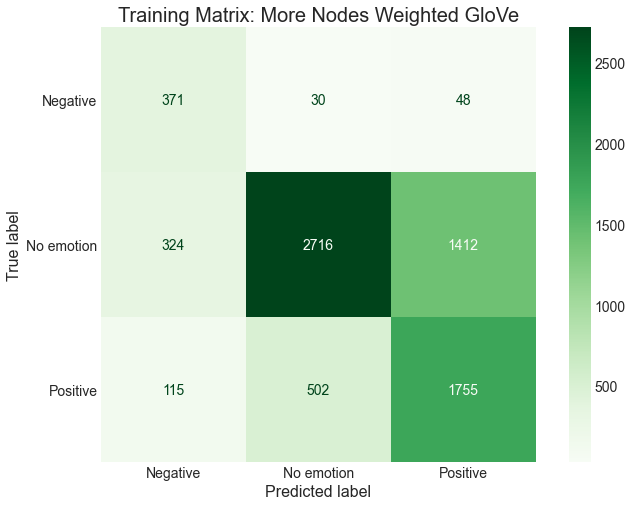

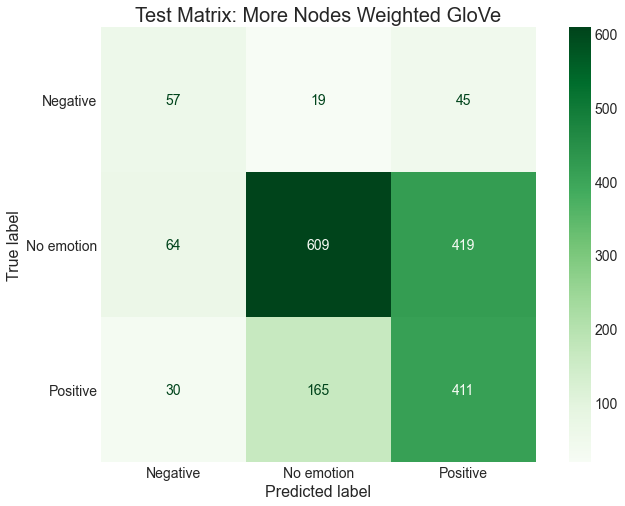

In [175]:
viz.make_network_confusion_matrices(w_more_lstm_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'More Nodes Weighted GloVe')

There are signs of overfitting starting around 10 epochs.

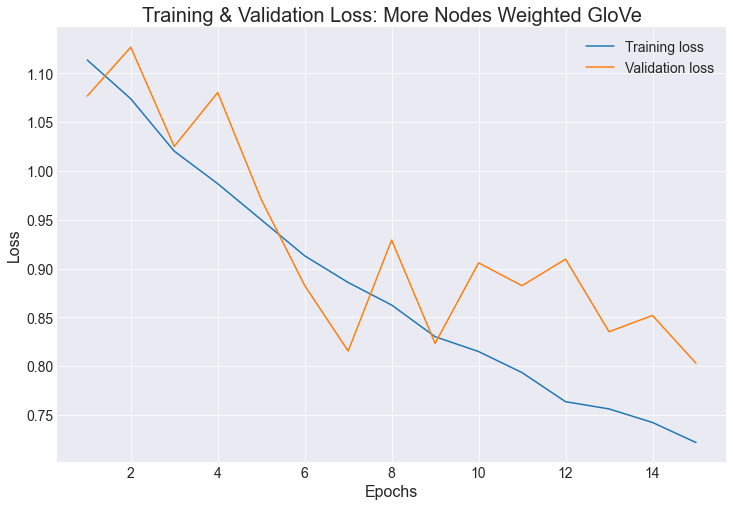

In [176]:
viz.training_graph(w_more_lstm_rnn_val_dict, 'More Nodes Weighted GloVe')

### Increasing Embedding Size

Let's try to increase the number of embedding dimensions to see if more meaning can be gleaned from the data that way.

In [177]:
more_embed_rnn = Sequential()
embedding_size = 256
more_embed_rnn.add(embedding_layer)
more_embed_rnn.add(LSTM(50, return_sequences=True))
more_embed_rnn.add(GlobalMaxPool1D())
more_embed_rnn.add(Dropout(0.5))
more_embed_rnn.add(Dense(50, activation='relu'))
more_embed_rnn.add(Dropout(0.5))
more_embed_rnn.add(Dense(3, activation='softmax'))
more_embed_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [178]:
more_embed_rnn_val = more_embed_rnn.fit(X_train_padded,
                                      y_train_rnn,epochs=12, 
                                      batch_size=32,
                                      validation_split=0.1)

Epoch 1/12
205/205 [==============================] - 8s 34ms/step - loss: 0.8810 - accuracy: 0.5723 - val_loss: 0.7697 - val_accuracy: 0.6511
Epoch 2/12
205/205 [==============================] - 6s 30ms/step - loss: 0.8231 - accuracy: 0.6167 - val_loss: 0.7376 - val_accuracy: 0.6648
Epoch 3/12
205/205 [==============================] - 6s 31ms/step - loss: 0.7888 - accuracy: 0.6307 - val_loss: 0.7078 - val_accuracy: 0.6978
Epoch 4/12
205/205 [==============================] - 6s 31ms/step - loss: 0.7667 - accuracy: 0.6429 - val_loss: 0.6921 - val_accuracy: 0.7074
Epoch 5/12
205/205 [==============================] - 7s 32ms/step - loss: 0.7402 - accuracy: 0.6608 - val_loss: 0.6812 - val_accuracy: 0.7115
Epoch 6/12
205/205 [==============================] - 6s 30ms/step - loss: 0.7237 - accuracy: 0.6695 - val_loss: 0.6733 - val_accuracy: 0.7060
Epoch 7/12
205/205 [==============================] - 6s 29ms/step - loss: 0.6978 - accuracy: 0.6900 - val_loss: 0.6585 - val_accuracy: 0.7253

In [179]:
more_embed_rnn_val_dict = more_embed_rnn_val.history

#### Metrics

This model also doesn't seem to perform significantly better than the original RNN model.

In [180]:
more_embed_metrics = dp.get_network_metrics(more_embed_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 3s 12ms/step - loss: 0.5545 - accuracy: 0.7594
----------
Training Loss: 0.554 
Training Accuracy: 0.759
Train F1 Score: 0.7443111474842963
Train Recall on Rarest Category: 0.289532293986637
57/57 [==============================] - 1s 12ms/step - loss: 0.7275 - accuracy: 0.6723
----------
Test Loss: 0.727 
Test Accuracy: 0.672
Test F1 Score: 0.6520143638664693
Test Recall on Rarest Category: 0.2066115702479339


#### Confusion Matrices

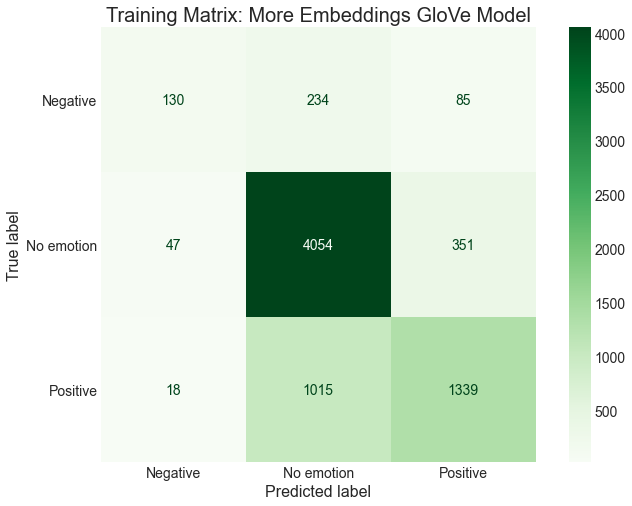

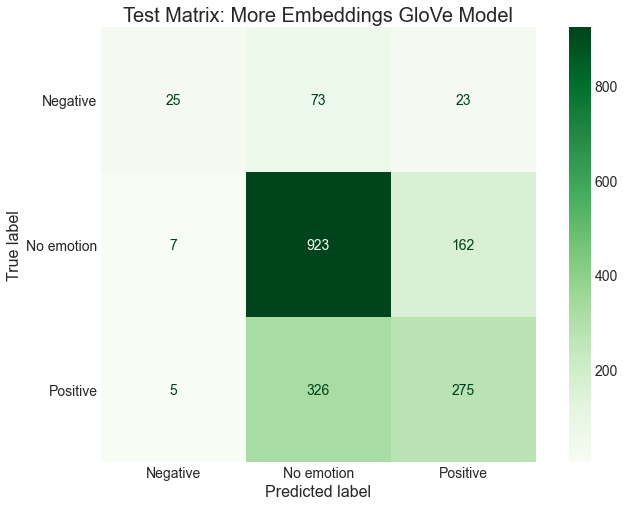

In [181]:
viz.make_network_confusion_matrices(more_embed_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'More Embeddings GloVe Model')

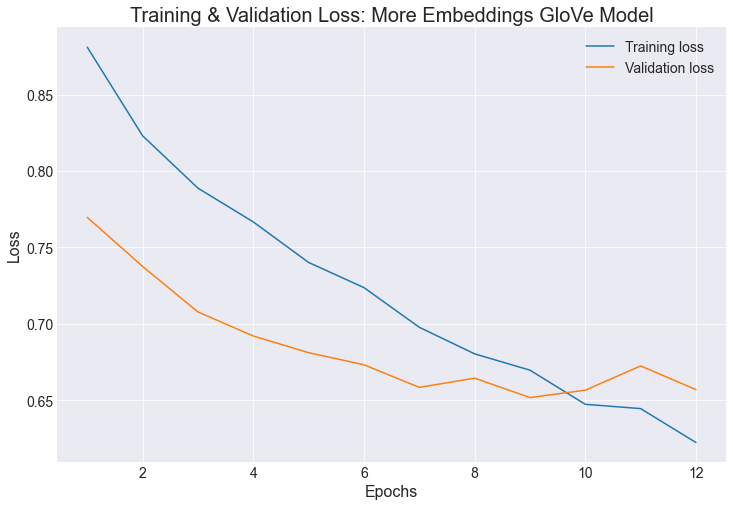

In [182]:
viz.training_graph(more_embed_rnn_val_dict, 'More Embeddings GloVe Model')

### *Adding Weighting*

In [185]:
w_more_embed_rnn = Sequential()
embedding_size = 256
w_more_embed_rnn.add(embedding_layer)
w_more_embed_rnn.add(LSTM(50, return_sequences=True))
w_more_embed_rnn.add(GlobalMaxPool1D())
w_more_embed_rnn.add(Dropout(0.5))
w_more_embed_rnn.add(Dense(50, activation='relu'))
w_more_embed_rnn.add(Dropout(0.5))
w_more_embed_rnn.add(Dense(3, activation='softmax'))
w_more_embed_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [186]:
w_more_embed_rnn_val = w_more_embed_rnn.fit(X_train_padded,
                                          y_train_rnn,epochs=20, 
                                          batch_size=32,
                                          validation_split=0.1,
                                           class_weight= d_class_weights)

Epoch 1/20
205/205 [==============================] - 9s 36ms/step - loss: 1.1014 - accuracy: 0.3583 - val_loss: 1.0609 - val_accuracy: 0.4560
Epoch 2/20
205/205 [==============================] - 7s 32ms/step - loss: 1.0487 - accuracy: 0.4101 - val_loss: 1.0757 - val_accuracy: 0.4203
Epoch 3/20
205/205 [==============================] - 6s 31ms/step - loss: 0.9895 - accuracy: 0.4591 - val_loss: 0.9586 - val_accuracy: 0.5206
Epoch 4/20
205/205 [==============================] - 7s 33ms/step - loss: 0.9330 - accuracy: 0.5016 - val_loss: 0.9149 - val_accuracy: 0.5316
Epoch 5/20
205/205 [==============================] - 7s 33ms/step - loss: 0.8998 - accuracy: 0.5363 - val_loss: 0.9580 - val_accuracy: 0.5179
Epoch 6/20
205/205 [==============================] - 6s 32ms/step - loss: 0.8655 - accuracy: 0.5435 - val_loss: 0.8413 - val_accuracy: 0.5975
Epoch 7/20
205/205 [==============================] - 7s 32ms/step - loss: 0.8479 - accuracy: 0.5592 - val_loss: 0.8252 - val_accuracy: 0.6360

In [187]:
w_more_embed_rnn_val_dict = w_more_embed_rnn_val.history

#### Metrics

Performs similarly to the others, but better than the unweighted version. Doesn't do as well as the previous weighted model on the rare category.

In [188]:
w_more_embed_metrics = dp.get_network_metrics(w_more_embed_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 3s 11ms/step - loss: 0.6716 - accuracy: 0.6997
----------
Training Loss: 0.672 
Training Accuracy: 0.7
Train F1 Score: 0.7117282208106526
Train Recall on Rarest Category: 0.9599109131403119
57/57 [==============================] - 1s 12ms/step - loss: 0.8397 - accuracy: 0.6102
----------
Test Loss: 0.84 
Test Accuracy: 0.61
Test F1 Score: 0.6231651412467051
Test Recall on Rarest Category: 0.6198347107438017


#### Confusion Matrices

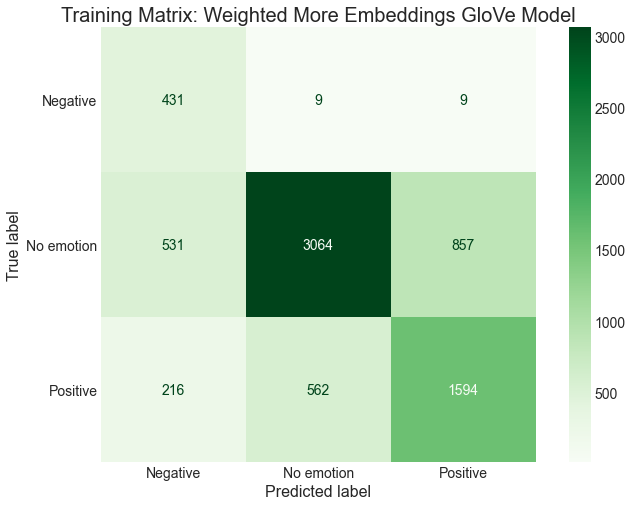

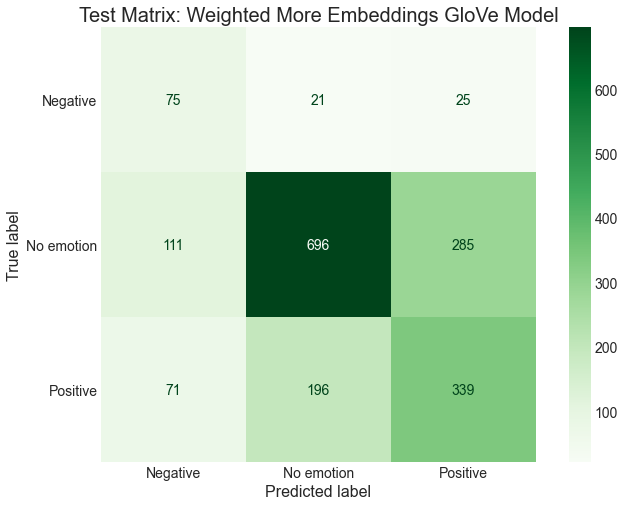

In [189]:
viz.make_network_confusion_matrices(w_more_embed_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted More Embeddings GloVe Model')

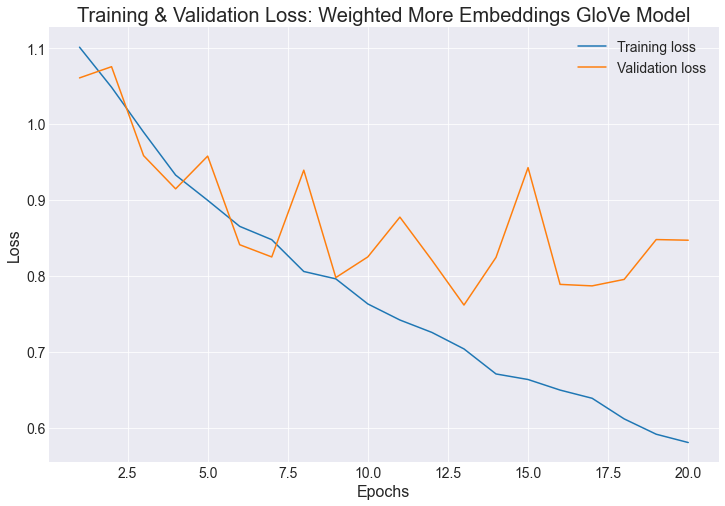

In [190]:
viz.training_graph(w_more_embed_rnn_val_dict, 'Weighted More Embeddings GloVe Model')

### Adding Depth

Let's try making the network deeper to see if that helps.

In [191]:
deeper_rnn = Sequential()
embedding_size = 128
deeper_rnn.add(embedding_layer)
deeper_rnn.add(LSTM(50, return_sequences=True))
deeper_rnn.add(Dropout(0.5))
deeper_rnn.add(LSTM(50, return_sequences=True))
deeper_rnn.add(GlobalMaxPool1D())
deeper_rnn.add(Dropout(0.5))
deeper_rnn.add(Dense(50, activation='relu'))
deeper_rnn.add(Dropout(0.5))
deeper_rnn.add(Dense(3, activation='softmax'))
deeper_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [192]:
deeper_rnn_val = deeper_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=10, 
                                batch_size=32,
                                validation_split=0.1)

Epoch 1/10
205/205 [==============================] - 16s 64ms/step - loss: 0.8853 - accuracy: 0.5811 - val_loss: 0.7955 - val_accuracy: 0.6511
Epoch 2/10
205/205 [==============================] - 14s 67ms/step - loss: 0.8367 - accuracy: 0.6061 - val_loss: 0.7725 - val_accuracy: 0.6511
Epoch 3/10
205/205 [==============================] - 12s 60ms/step - loss: 0.8003 - accuracy: 0.6240 - val_loss: 0.7366 - val_accuracy: 0.6827
Epoch 4/10
205/205 [==============================] - 12s 58ms/step - loss: 0.7686 - accuracy: 0.6477 - val_loss: 0.6985 - val_accuracy: 0.7005
Epoch 5/10
205/205 [==============================] - 12s 61ms/step - loss: 0.7391 - accuracy: 0.6645 - val_loss: 0.7009 - val_accuracy: 0.6937
Epoch 6/10
205/205 [==============================] - 12s 60ms/step - loss: 0.7248 - accuracy: 0.6787 - val_loss: 0.6768 - val_accuracy: 0.7143
Epoch 7/10
205/205 [==============================] - 14s 68ms/step - loss: 0.6890 - accuracy: 0.6935 - val_loss: 0.6891 - val_accuracy:

In [193]:
deeper_rnn_val_dict = deeper_rnn_val.history

#### Metrics

The deeper model performed marginally better with F1 score than the baseline model. The model doesn't do well on the rare category.

In [194]:
deeper_rnn_metrics = dp.get_network_metrics(deeper_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 4s 19ms/step - loss: 0.5747 - accuracy: 0.7476
----------
Training Loss: 0.575 
Training Accuracy: 0.748
Train F1 Score: 0.7241252437349234
Train Recall on Rarest Category: 0.24276169265033407
57/57 [==============================] - 1s 19ms/step - loss: 0.7215 - accuracy: 0.6745
----------
Test Loss: 0.722 
Test Accuracy: 0.675
Test F1 Score: 0.6427320695380347
Test Recall on Rarest Category: 0.17355371900826447


#### Confusion Matrices

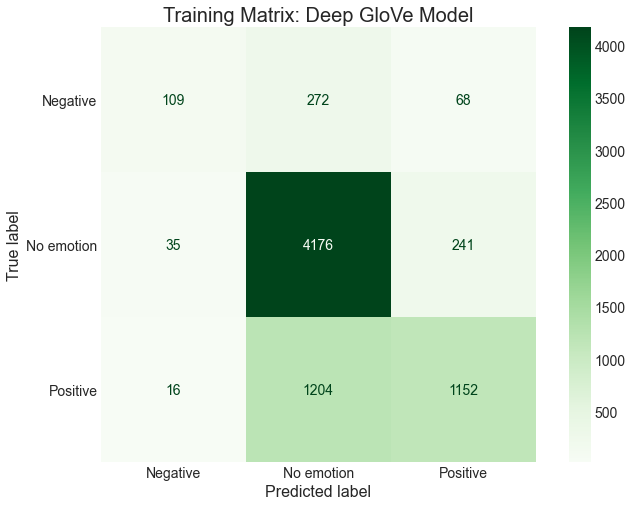

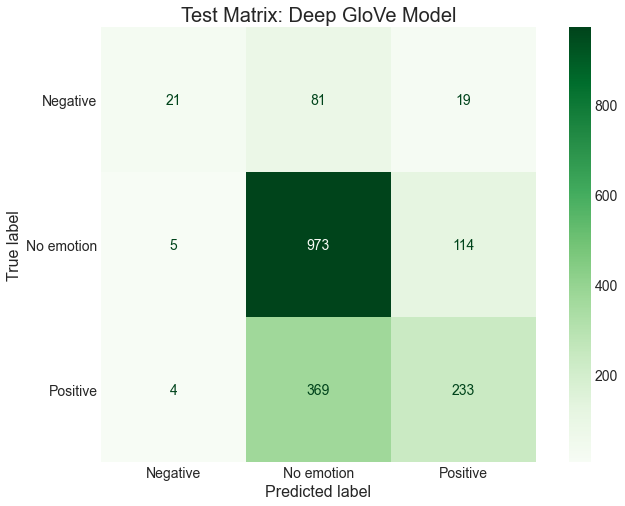

In [195]:
viz.make_network_confusion_matrices(deeper_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Deep GloVe Model')


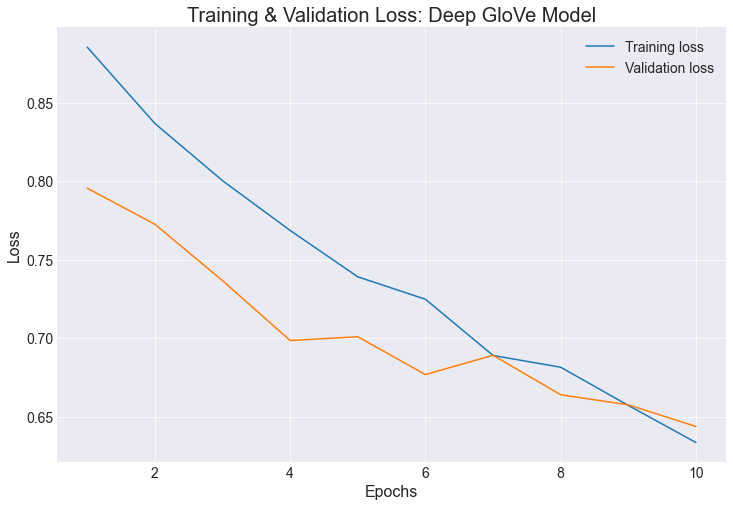

In [196]:
viz.training_graph(deeper_rnn_val_dict, 'Deep GloVe Model')

### *Adding Weights*

In [197]:
w_deeper_rnn = Sequential()
embedding_size = 128
w_deeper_rnn.add(embedding_layer)
w_deeper_rnn.add(LSTM(50, return_sequences=True))
w_deeper_rnn.add(Dropout(0.5))
w_deeper_rnn.add(LSTM(50, return_sequences=True))
w_deeper_rnn.add(GlobalMaxPool1D())
w_deeper_rnn.add(Dropout(0.5))
w_deeper_rnn.add(Dense(50, activation='relu'))
w_deeper_rnn.add(Dropout(0.5))
w_deeper_rnn.add(Dense(3, activation='softmax'))
w_deeper_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [198]:
w_deeper_rnn_val = w_deeper_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=15, 
                                batch_size=32,
                                validation_split=0.1,
                               class_weight= d_class_weights)

Epoch 1/15
205/205 [==============================] - 15s 61ms/step - loss: 1.0909 - accuracy: 0.3410 - val_loss: 1.0696 - val_accuracy: 0.4547
Epoch 2/15
205/205 [==============================] - 12s 61ms/step - loss: 1.0275 - accuracy: 0.4290 - val_loss: 1.0713 - val_accuracy: 0.4643
Epoch 3/15
205/205 [==============================] - 13s 63ms/step - loss: 0.9707 - accuracy: 0.4848 - val_loss: 0.9098 - val_accuracy: 0.5755
Epoch 4/15
205/205 [==============================] - 13s 62ms/step - loss: 0.9304 - accuracy: 0.5259 - val_loss: 0.9051 - val_accuracy: 0.6154
Epoch 5/15
205/205 [==============================] - 13s 63ms/step - loss: 0.8925 - accuracy: 0.5575 - val_loss: 0.9116 - val_accuracy: 0.5934
Epoch 6/15
205/205 [==============================] - 13s 61ms/step - loss: 0.8486 - accuracy: 0.5763 - val_loss: 0.9040 - val_accuracy: 0.6003
Epoch 7/15
205/205 [==============================] - 13s 64ms/step - loss: 0.8156 - accuracy: 0.5812 - val_loss: 0.8494 - val_accuracy:

In [199]:
w_deeper_rnn_val_dict = w_deeper_rnn_val.history

#### Metrics

Doesn't do better than other weighted models on F1 or accuracy, but does very well on recall for rare category.

In [200]:
w_deeper_metrics = dp.get_network_metrics(w_deeper_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 4s 19ms/step - loss: 0.6268 - accuracy: 0.7205
----------
Training Loss: 0.627 
Training Accuracy: 0.72
Train F1 Score: 0.723507186445968
Train Recall on Rarest Category: 0.9086859688195991
57/57 [==============================] - 1s 19ms/step - loss: 0.8398 - accuracy: 0.6399
----------
Test Loss: 0.84 
Test Accuracy: 0.64
Test F1 Score: 0.6454006885376473
Test Recall on Rarest Category: 0.5041322314049587


#### Confusion Matrices

But even those this model has high recall on the rare data, it comes at the cost of a lot of false positives, and a clearly low precision.

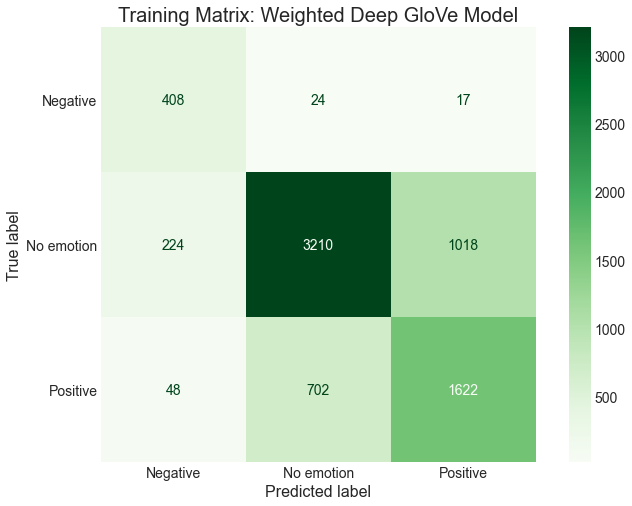

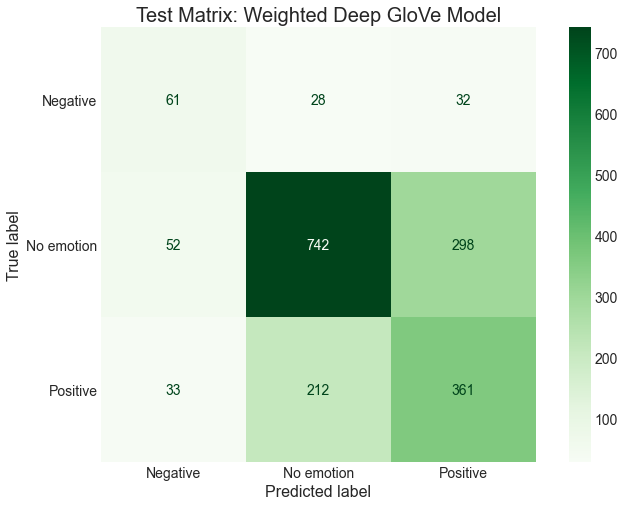

In [201]:
viz.make_network_confusion_matrices(w_deeper_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted Deep GloVe Model')

Clear signs of overfitting around the 8th epoch.

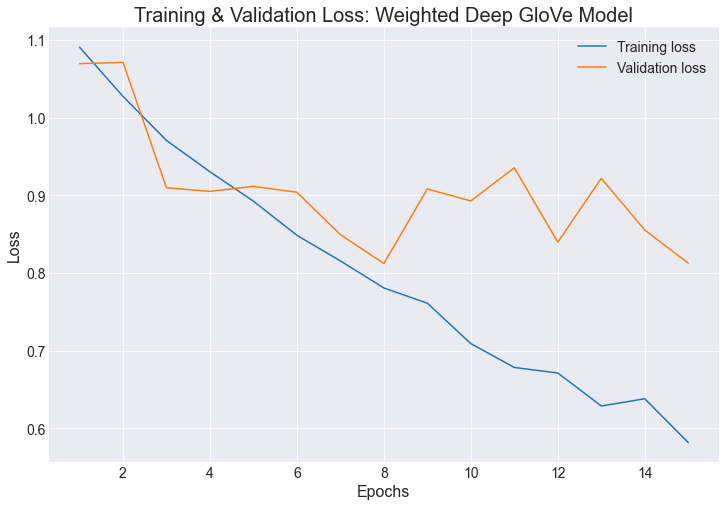

In [202]:
viz.training_graph(w_deeper_rnn_val_dict, 'Weighted Deep GloVe Model')

### *Even Deeper*

In [203]:
deepest_rnn = Sequential()
embedding_size = 128
deepest_rnn.add(embedding_layer)
deepest_rnn.add(LSTM(50, return_sequences=True))
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(LSTM(50, return_sequences=True))
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(LSTM(50, return_sequences=True))
deepest_rnn.add(GlobalMaxPool1D())
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(Dense(50, activation='relu'))
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(Dense(3, activation='softmax'))
deepest_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [204]:
deepest_rnn_val = deepest_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=12, 
                                batch_size=32,
                                validation_split=0.1)

Epoch 1/12
205/205 [==============================] - 24s 96ms/step - loss: 0.8806 - accuracy: 0.5922 - val_loss: 0.8290 - val_accuracy: 0.6511
Epoch 2/12
205/205 [==============================] - 19s 94ms/step - loss: 0.8309 - accuracy: 0.6070 - val_loss: 0.7538 - val_accuracy: 0.6786
Epoch 3/12
205/205 [==============================] - 20s 97ms/step - loss: 0.8038 - accuracy: 0.6248 - val_loss: 0.7299 - val_accuracy: 0.6964
Epoch 4/12
205/205 [==============================] - 19s 93ms/step - loss: 0.7686 - accuracy: 0.6492 - val_loss: 0.7020 - val_accuracy: 0.7115
Epoch 5/12
205/205 [==============================] - 20s 97ms/step - loss: 0.7382 - accuracy: 0.6712 - val_loss: 0.6925 - val_accuracy: 0.6937
Epoch 6/12
205/205 [==============================] - 21s 102ms/step - loss: 0.7223 - accuracy: 0.6820 - val_loss: 0.6850 - val_accuracy: 0.6937
Epoch 7/12
205/205 [==============================] - 21s 101ms/step - loss: 0.7043 - accuracy: 0.6885 - val_loss: 0.6821 - val_accurac

In [205]:
deepest_rnn_val_dict = deepest_rnn_val.history

#### Metrics

Does well on accuracy but more poorly on F1 score than baseline. Does poorly with the rare data.

In [206]:
deepest_metrics = dp.get_network_metrics(deepest_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 7s 31ms/step - loss: 0.5331 - accuracy: 0.7735
----------
Training Loss: 0.533 
Training Accuracy: 0.774
Train F1 Score: 0.7596170474420747
Train Recall on Rarest Category: 0.4521158129175947
57/57 [==============================] - 2s 29ms/step - loss: 0.7361 - accuracy: 0.6734
----------
Test Loss: 0.736 
Test Accuracy: 0.673
Test F1 Score: 0.6490597734961493
Test Recall on Rarest Category: 0.24793388429752067


#### Confusion Matrices

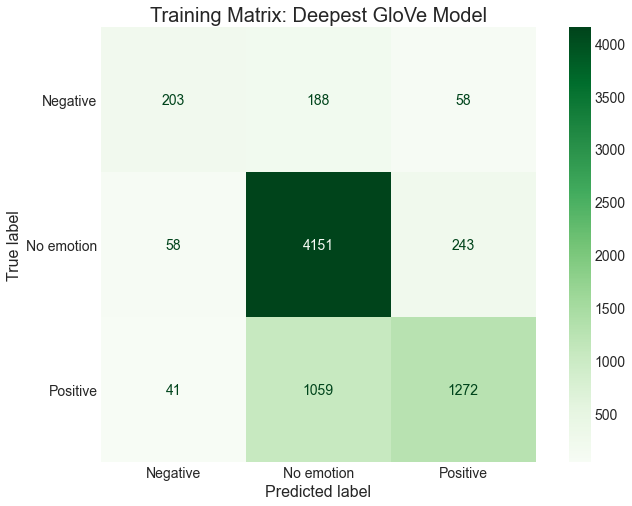

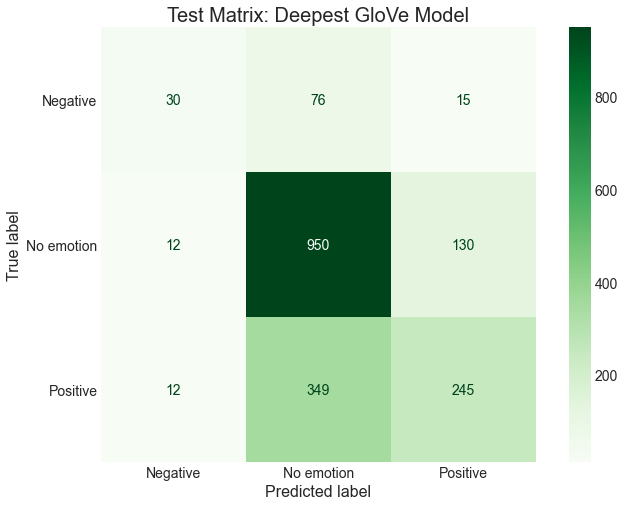

In [207]:
viz.make_network_confusion_matrices(deepest_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Deepest GloVe Model')

Validation is plateauing a bit, but no clear signs of major overfitting.

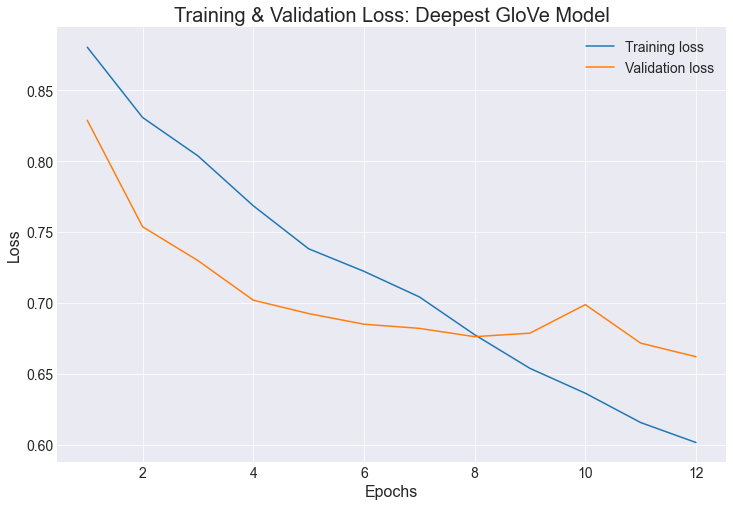

In [208]:
viz.training_graph(deepest_rnn_val_dict, 'Deepest GloVe Model')

### *Adding Weights*

In [209]:
w_deepest_rnn = Sequential()
embedding_size = 128
w_deepest_rnn.add(embedding_layer)
w_deepest_rnn.add(LSTM(50, return_sequences=True))
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(LSTM(50, return_sequences=True))
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(LSTM(50, return_sequences=True))
w_deepest_rnn.add(GlobalMaxPool1D())
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(Dense(50, activation='relu'))
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(Dense(3, activation='softmax'))
w_deepest_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [210]:
w_deepest_rnn_val = w_deepest_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=15, 
                                batch_size=32,
                                validation_split=0.1,
                               class_weight= d_class_weights)

Epoch 1/15
205/205 [==============================] - 24s 98ms/step - loss: 1.0894 - accuracy: 0.3086 - val_loss: 1.0439 - val_accuracy: 0.4657
Epoch 2/15
205/205 [==============================] - 20s 99ms/step - loss: 1.0559 - accuracy: 0.4382 - val_loss: 1.0479 - val_accuracy: 0.4657
Epoch 3/15
205/205 [==============================] - 21s 100ms/step - loss: 1.0081 - accuracy: 0.4652 - val_loss: 1.0522 - val_accuracy: 0.5069
Epoch 4/15
205/205 [==============================] - 20s 97ms/step - loss: 0.9693 - accuracy: 0.4865 - val_loss: 1.0329 - val_accuracy: 0.5398
Epoch 5/15
205/205 [==============================] - 20s 98ms/step - loss: 0.9239 - accuracy: 0.5235 - val_loss: 0.8298 - val_accuracy: 0.6346
Epoch 6/15
205/205 [==============================] - 19s 94ms/step - loss: 0.8748 - accuracy: 0.5274 - val_loss: 0.9376 - val_accuracy: 0.5920
Epoch 7/15
205/205 [==============================] - 21s 100ms/step - loss: 0.8333 - accuracy: 0.5575 - val_loss: 0.9481 - val_accurac

In [211]:
w_deepest_rnn_val_dict = w_deepest_rnn_val.history

#### Metrics

Does poorly on F1 and accuracy and has poor recall compared to previous weighted models.

In [212]:
w_deepest_metrics = dp.get_network_metrics(w_deepest_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 7s 30ms/step - loss: 0.6531 - accuracy: 0.7020
----------
Training Loss: 0.653 
Training Accuracy: 0.702
Train F1 Score: 0.7054406416080413
Train Recall on Rarest Category: 0.9220489977728286
57/57 [==============================] - 2s 30ms/step - loss: 0.8411 - accuracy: 0.6091
----------
Test Loss: 0.841 
Test Accuracy: 0.609
Test F1 Score: 0.6158478049668938
Test Recall on Rarest Category: 0.6033057851239669


#### Confusion Matrices

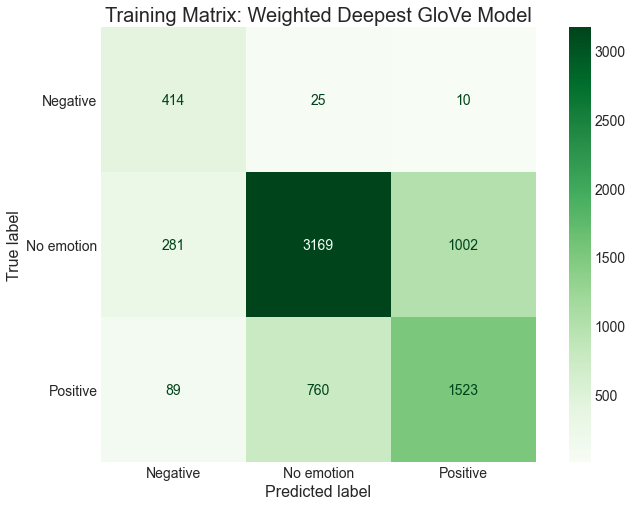

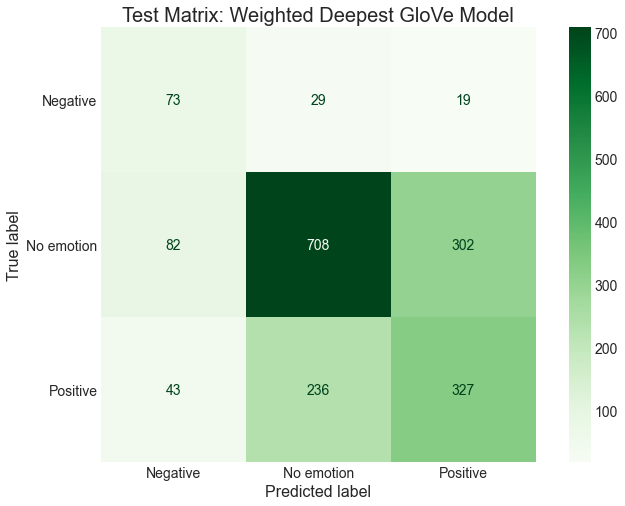

In [213]:
viz.make_network_confusion_matrices(w_deepest_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted Deepest GloVe Model')


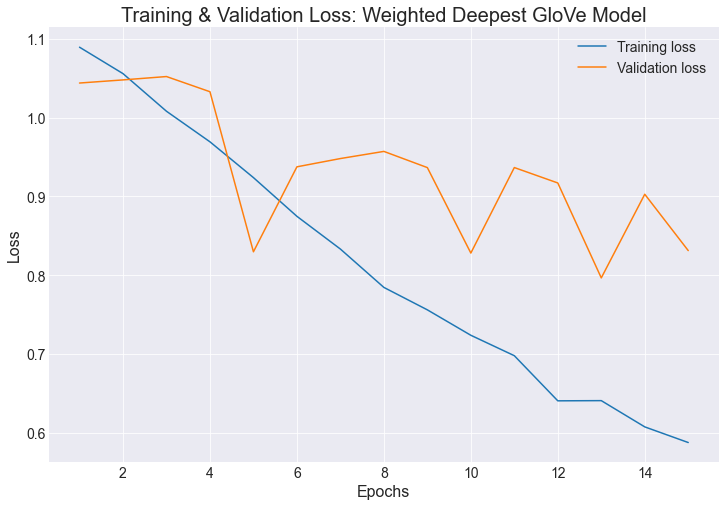

In [214]:
viz.training_graph(w_deepest_rnn_val_dict, 'Weighted Deepest GloVe Model')

## Graphing Model Performance

In [215]:
baseline_metrics['Test F1']

0.6535745385833527

In [228]:
F1_scores = {'Baseline (3 layer)': [baseline_metrics['Test F1']],
             'Weighted': [weighted_metrics['Test F1']],
             'Baseline GloVe': [glove_metrics['Test F1']],
             'Weighted GloVe': [wglove_metrics['Test F1']],
             'More Nodes': [more_lstm_metrics['Test F1']],
             'Weighted More Nodes': [w_more_lstm_metrics['Test F1']],
             'More Embedding': [more_embed_metrics['Test F1']],
             'Weighted More Embedding': [w_more_embed_metrics['Test F1']],
             '4 layer': [deeper_rnn_metrics['Test F1']],
             'Weighted 4 layer': [w_deeper_metrics['Test F1']],
             '5 layer': [deepest_metrics['Test F1']],
             'Weighted 5 layer': [w_deepest_metrics['Test F1']]
            }

F1_df = pd.DataFrame.from_dict(F1_scores, orient='index')
F1_df.columns = ['F1 Score']

In [229]:
F1_df.head()

,F1 Score
Baseline (3 layer),0.653575
Weighted,0.636221
Baseline GloVe,0.654935
Weighted GloVe,0.620873
More Nodes,0.655097


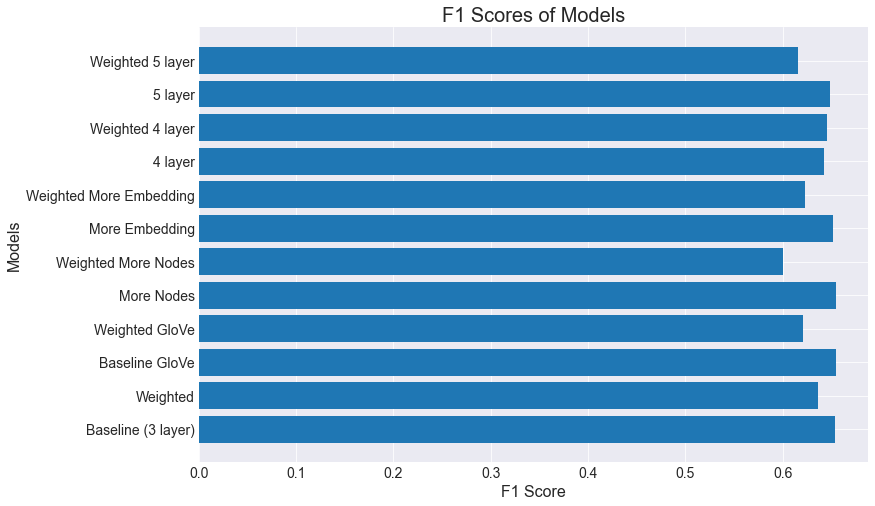

In [230]:
plt.barh(F1_df.index, F1_df['F1 Score'])
plt.title('F1 Scores of Models')
plt.xlabel('F1 Score')
plt.ylabel('Models')
plt.show()

In [231]:
Neg_Recall = {'Baseline': [baseline_metrics['Test Rare Recall']],
             'Weighted': [weighted_metrics['Test Rare Recall']],
             'Baseline GloVe': [glove_metrics['Test Rare Recall']],
             'Weighted GloVe': [wglove_metrics['Test Rare Recall']],
             'More Nodes': [more_lstm_metrics['Test Rare Recall']],
             'Weighted More Nodes': [w_more_lstm_metrics['Test Rare Recall']],
             'More Embedding': [more_embed_metrics['Test Rare Recall']],
             'Weighted More Embedding': [w_more_embed_metrics['Test Rare Recall']],
              '4 layer': [deeper_rnn_metrics['Test Rare Recall']],
             'Weighted 4 layer': [w_deeper_metrics['Test Rare Recall']],
             '5 layer': [deepest_metrics['Test Rare Recall']],
             'Weighted 5 layer': [w_deepest_metrics['Test Rare Recall']]
            }
Recall_df = pd.DataFrame.from_dict(Neg_Recall, orient='index')
Recall_df.columns = ['Rare Recall']

In [232]:
Recall_df.head()

,Rare Recall
Baseline,0.297521
Weighted,0.396694
Baseline GloVe,0.181818
Weighted GloVe,0.537190
More Nodes,0.214876


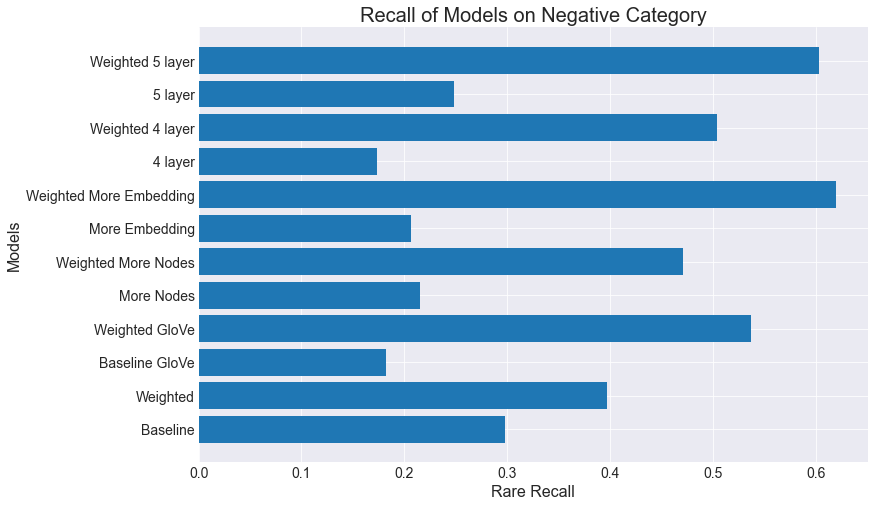

In [233]:
plt.barh(Recall_df.index, Recall_df['Rare Recall'])
plt.title('Recall of Models on Negative Category')
plt.xlabel('Rare Recall')
plt.ylabel('Models')
plt.show()